In [79]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

In [80]:
!pip install imblearn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [81]:
df = pd.read_csv("./dataset/processed_dataset_attacks_only.csv", low_memory=False)
df = df.dropna()

In [82]:
scaler = StandardScaler()

# Check what columns exist in the dataset
print("Available columns:")
print(df.columns.tolist())

# Drop columns that exist
columns_to_drop = []
if "Attack_label" in df.columns:
    columns_to_drop.append("Attack_label")
if "Attack_class" in df.columns:
    columns_to_drop.append("Attack_class")

if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
    print(f"Dropped columns: {columns_to_drop}")

X_scaled = scaler.fit_transform(df.drop(columns=["Attack_type"]))
y = df["Attack_type"]
print("Feature scaling complete!")

Available columns:
['arp.opcode', 'icmp.checksum', 'icmp.seq_le', 'http.content_length', 'http.response', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'udp.stream', 'udp.time_delta', 'dns.qry.qu', 'dns.retransmission', 'dns.retransmit_request', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.ver', 'Attack_label', 'Attack_type']
Dropped columns: ['Attack_label']
Feature scaling complete!


In [127]:
df.columns

Index(['arp.opcode', 'icmp.checksum', 'icmp.seq_le', 'http.content_length',
       'http.response', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.flags',
       'tcp.flags.ack', 'tcp.len', 'udp.stream', 'udp.time_delta',
       'dns.qry.qu', 'dns.retransmission', 'dns.retransmit_request',
       'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msgtype',
       'mqtt.proto_len', 'mqtt.ver', 'Attack_type'],
      dtype='object')

In [83]:
pca = PCA(n_components=0.99)  # Increased from 0.95 to 0.99
X_pca = pca.fit_transform(X_scaled)

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save PCA and scaler
joblib.dump(pca, 'models/pca.pkl')
joblib.dump(scaler, 'models/standard_scaler.pkl')
print(f"Original features: {X_scaled.shape[1]}, Reduced features: {X_pca.shape[1]}")
print("PCA and scaler saved to models/ directory")

Original features: 23, Reduced features: 14
PCA and scaler saved to models/ directory


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")


Training set: (331361, 14), Validation set: (82841, 14), Testing set: (103551, 14)


In [85]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training set: {X_train_resampled.shape}")

Resampled training set: (1011439, 14)


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [87]:
# Convert labels to string for encoding
y_train_str = y_train.astype(str)
y_val_str = y_val.astype(str)
y_test_str = y_test.astype(str)

# Combine all label sets to preserve unseen classes for encoding
combined_labels = np.concatenate([y_train_str, y_val_str, y_test_str])
label_encoder = LabelEncoder()
label_encoder.fit(combined_labels)

# Transform labels to integers
y_train_encoded = label_encoder.transform(y_train_str)
y_val_encoded = label_encoder.transform(y_val_str)
y_test_encoded = label_encoder.transform(y_test_str)

# Create a mapping of label name to encoded value
label_to_id = {name: idx for idx, name in enumerate(label_encoder.classes_)}
id_to_label = {idx: name for name, idx in label_to_id.items()}

# Select underperforming classes to boost
underperforming = ['XSS', 'MITM', 'Password', 'Port_Scanning']

# Target number of samples for each
smote_strategy = {
    label_to_id[label]: 50000 for label in underperforming
}

# Apply SMOTE only to selected classes
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Check counts
print("New class distribution after targeted SMOTE:")
print({id_to_label[k]: v for k, v in Counter(y_train_resampled).items()})

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['Attack_type'])

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save label encoder and feature order
joblib.dump(label_encoder, 'models/label_encoder.pkl')

# Save feature order for inference
feature_order = df.drop(columns=["Attack_type"]).columns.tolist()
joblib.dump(feature_order, 'models/feature_order.pkl')

# Save model metadata
model_metadata = {
    'input_dim': X_pca.shape[1],
    'num_classes': len(label_encoder.classes_),
    'class_names': label_encoder.classes_.tolist(),
    'pca_components': 0.99,
    'original_features': X_scaled.shape[1],
    'reduced_features': X_pca.shape[1]
}
joblib.dump(model_metadata, 'models/model_metadata.pkl')

print("Label encoder, feature order, and model metadata saved to models/ directory")

New class distribution after targeted SMOTE:
{'Backdoor': 14757, 'DDoS_HTTP': 29922, 'Password': 50000, 'DDoS_UDP': 77803, 'DDoS_TCP': 26550, 'SQL_injection': 29468, 'DDoS_ICMP': 43481, 'Uploading': 22608, 'Vulnerability_scanner': 30382, 'Port_Scanning': 50000, 'Ransomware': 6040, 'XSS': 50000, 'MITM': 50000}
Label encoder, feature order, and model metadata saved to models/ directory

{'Backdoor': 14757, 'DDoS_HTTP': 29922, 'Password': 50000, 'DDoS_UDP': 77803, 'DDoS_TCP': 26550, 'SQL_injection': 29468, 'DDoS_ICMP': 43481, 'Uploading': 22608, 'Vulnerability_scanner': 30382, 'Port_Scanning': 50000, 'Ransomware': 6040, 'XSS': 50000, 'MITM': 50000}
Label encoder, feature order, and model metadata saved to models/ directory


In [88]:
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)


X_train_resampled shape: (481011, 14)
y_train_resampled shape: (481011,)


In [89]:
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32)

In [90]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save y tensors to models directory
torch.save(y_train_tensor, "models/y_train_tensor.pt")
torch.save(y_val_tensor, "models/y_val_tensor.pt")
torch.save(y_test_tensor, "models/y_test_tensor.pt")

In [91]:
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [92]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save tensors to models directory
torch.save(X_train_tensor, "models/X_train_tensor.pt")
torch.save(X_val_tensor, "models/X_val_tensor.pt")
torch.save(X_test_tensor, "models/X_test_tensor.pt")

In [93]:
print("X_train_resampled shape:", X_train_tensor.shape)
print("y_train_resampled shape:", y_train_tensor.shape)


X_train_resampled shape: torch.Size([481011, 14])
y_train_resampled shape: torch.Size([481011])


In [94]:
unique_classes = np.unique(y_train_resampled)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [95]:
batch_size = 512  # Increased from 128 to 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [96]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

In [97]:
accumulation_steps = 4


In [98]:
class ImprovedDNN(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.3):
        super(ImprovedDNN, self).__init__()
        
        # Wider architecture with batch normalization
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, num_classes)

        # Activation & regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.act = nn.LeakyReLU(0.1)  # LeakyReLU instead of ReLU

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.act(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.act(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [99]:
input_dim = X_train_resampled.shape[1]
num_classes = len(set(y_train_resampled))
print(input_dim,num_classes)

model = ImprovedDNN(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


14 13


In [100]:
num_epochs = 20
best_val_acc = 0
patience = 5
patience_counter = 0

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    optimizer.zero_grad()  # Reset gradients at the beginning of epoch
    
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for i, (X_batch, y_batch) in enumerate(tepoch):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Normalize loss to account for accumulation
            loss = loss / accumulation_steps
            loss.backward()
            
            # Only step and zero_grad after accumulation_steps
            if (i + 1) % accumulation_steps == 0:
                # Add gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            running_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            tepoch.set_postfix(loss=loss.item() * accumulation_steps, accuracy=correct/total)
    
    # Step optimizer for remaining gradients
    if len(train_loader) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f} - Train Accuracy: {train_acc:.4f}")
    
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()
    
    val_acc = val_correct / val_total
    val_loss = val_loss / len(val_loader)
    
    print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'models/best_model.pt')
        print(f"Best model weights saved with validation accuracy: {best_val_acc:.4f}")
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Load the best model weights for evaluation
model.load_state_dict(torch.load('models/best_model.pt'))
model.eval()

Epoch 1/20: 100%|██████████| 940/940 [00:06<00:00, 147.77batch/s, accuracy=0.512, loss=1.34]


Epoch [1/20] - Loss: 1.5137 - Train Accuracy: 0.5124
Validation Loss: 1.3488 - Validation Accuracy: 0.6080
Best model weights saved with validation accuracy: 0.6080
Validation Loss: 1.3488 - Validation Accuracy: 0.6080
Best model weights saved with validation accuracy: 0.6080


Epoch 2/20: 100%|██████████| 940/940 [00:05<00:00, 167.07batch/s, accuracy=0.584, loss=1.34]


Epoch [2/20] - Loss: 1.2904 - Train Accuracy: 0.5843
Validation Loss: 1.2067 - Validation Accuracy: 0.6300
Best model weights saved with validation accuracy: 0.6300
Validation Loss: 1.2067 - Validation Accuracy: 0.6300
Best model weights saved with validation accuracy: 0.6300


Epoch 3/20: 100%|██████████| 940/940 [00:05<00:00, 170.33batch/s, accuracy=0.615, loss=1.19]


Epoch [3/20] - Loss: 1.1989 - Train Accuracy: 0.6150
Validation Loss: 1.1478 - Validation Accuracy: 0.6358
Best model weights saved with validation accuracy: 0.6358
Validation Loss: 1.1478 - Validation Accuracy: 0.6358
Best model weights saved with validation accuracy: 0.6358


Epoch 4/20: 100%|██████████| 940/940 [00:05<00:00, 170.35batch/s, accuracy=0.628, loss=1.26]


Epoch [4/20] - Loss: 1.1529 - Train Accuracy: 0.6282
Validation Loss: 1.1307 - Validation Accuracy: 0.6101
Validation Loss: 1.1307 - Validation Accuracy: 0.6101


Epoch 5/20: 100%|██████████| 940/940 [00:05<00:00, 164.98batch/s, accuracy=0.634, loss=1.28]


Epoch [5/20] - Loss: 1.1321 - Train Accuracy: 0.6345
Validation Loss: 1.1072 - Validation Accuracy: 0.6300
Validation Loss: 1.1072 - Validation Accuracy: 0.6300


Epoch 6/20: 100%|██████████| 940/940 [00:06<00:00, 145.96batch/s, accuracy=0.64, loss=1.25]


Epoch [6/20] - Loss: 1.1166 - Train Accuracy: 0.6397
Validation Loss: 1.0965 - Validation Accuracy: 0.6231
Validation Loss: 1.0965 - Validation Accuracy: 0.6231


Epoch 7/20: 100%|██████████| 940/940 [00:06<00:00, 138.55batch/s, accuracy=0.643, loss=1.15]


Epoch [7/20] - Loss: 1.1064 - Train Accuracy: 0.6429
Validation Loss: 1.0849 - Validation Accuracy: 0.6343
Validation Loss: 1.0849 - Validation Accuracy: 0.6343


Epoch 8/20: 100%|██████████| 940/940 [00:05<00:00, 157.46batch/s, accuracy=0.645, loss=1.26]


Epoch [8/20] - Loss: 1.0995 - Train Accuracy: 0.6453
Validation Loss: 1.0884 - Validation Accuracy: 0.6135
Early stopping triggered!
Validation Loss: 1.0884 - Validation Accuracy: 0.6135
Early stopping triggered!


ImprovedDNN(
  (fc1): Linear(in_features=14, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=13, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (act): LeakyReLU(negative_slope=0.1)
)

In [101]:
model.eval()

ImprovedDNN(
  (fc1): Linear(in_features=14, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=13, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (act): LeakyReLU(negative_slope=0.1)
)

In [102]:
def evaluate(model, test_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader, desc="Evaluating"):
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_test.cpu().numpy())

    class_names = label_encoder.classes_

    # Safely map predictions to class names
    pred_classes = [class_names[int(i)] for i in all_preds]
    target_classes = [class_names[int(i)] for i in all_targets]

    print("\n📊 Classification Report:")
    print(classification_report(target_classes, pred_classes))

    cm = confusion_matrix(target_classes, pred_classes)
    return cm, classification_report(target_classes, pred_classes, output_dict=True)


In [103]:
print("Evaluating model on test set...")
cm, report = evaluate(model, test_loader, device, label_encoder)
print("Test evaluation complete!")

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the model and results in the models directory
torch.save(model.state_dict(), 'models/final_model.pt')
joblib.dump(report, 'models/classification_report.pkl')
print("Model and evaluation results saved to models/ directory.")

Evaluating model on test set...


Evaluating: 100%|██████████| 203/203 [00:00<00:00, 482.38it/s]




📊 Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.42      0.31      0.36      4612
            DDoS_HTTP       0.65      0.27      0.38      9350
            DDoS_ICMP       1.00      0.99      0.99     13588
             DDoS_TCP       1.00      0.57      0.73      8297
             DDoS_UDP       0.99      1.00      1.00     24313
                 MITM       1.00      1.00      1.00        23
             Password       0.74      0.10      0.17      9101
        Port_Scanning       0.25      1.00      0.40      3705
           Ransomware       0.37      0.40      0.38      1888
        SQL_injection       0.27      0.71      0.39      9209
            Uploading       0.98      0.06      0.11      7065
Vulnerability_scanner       0.92      0.74      0.82      9494
                  XSS       0.11      0.13      0.12      2906

             accuracy                           0.64    103551
            macro avg      

# 🚀 Model Improvements

Based on the current performance (65% accuracy), we can see several issues:
- **Poor performance on minority classes**: XSS (11%), Uploading (11%), SQL_injection (22%)
- **Class imbalance effects**: Some classes like DDoS_UDP perform very well (100%) while others struggle
- **Need for better architecture and training strategies**

Let's implement several improvements:

In [104]:
import torch.nn.functional as F
from torch.nn import MultiheadAttention

class AdvancedDNN(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.4):
        super(AdvancedDNN, self).__init__()
        
        # Enhanced architecture with residual connections
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.fc3 = nn.Linear(512, 512)  # Same dimension for residual
        self.bn3 = nn.BatchNorm1d(512)
        
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        
        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(64)
        
        # Final classifier with multiple heads
        self.classifier = nn.Linear(64, num_classes)
        
        # Attention mechanism
        self.attention = MultiheadAttention(embed_dim=512, num_heads=8, dropout=0.1, batch_first=True)
        
        # Regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.dropout_light = nn.Dropout(0.2)
        
        # Advanced activation
        self.act = nn.LeakyReLU(0.1)
        self.swish = nn.SiLU()  # Swish activation
        
    def forward(self, x):
        # Initial layers with enhanced depth
        x = self.swish(self.bn1(self.fc1(x)))
        x = self.dropout_light(x)
        
        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout_light(x)
        
        # Residual connection
        residual = x
        x = self.act(self.bn3(self.fc3(x)))
        x = x + residual  # Skip connection
        x = self.dropout(x)
        
        # Attention mechanism (reshape for attention)
        x_att = x.unsqueeze(1)  # Add sequence dimension
        attn_out, _ = self.attention(x_att, x_att, x_att)
        x = attn_out.squeeze(1)  # Remove sequence dimension
        
        x = self.act(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        
        x = self.act(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        
        x = self.act(self.bn6(self.fc6(x)))
        x = self.dropout_light(x)
        
        # Final classification
        x = self.classifier(x)
        return x

print("Advanced DNN architecture created with:")
print("- Residual connections")
print("- Multi-head attention")
print("- Enhanced depth (1024->512->512->256->128->64)")
print("- Mixed activation functions (SiLU + LeakyReLU)")
print("- Advanced dropout strategy")

Advanced DNN architecture created with:
- Residual connections
- Multi-head attention
- Enhanced depth (1024->512->512->256->128->64)
- Mixed activation functions (SiLU + LeakyReLU)
- Advanced dropout strategy


In [105]:
# 📊 Improved Data Balancing Strategy
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# Analyze current class distribution
print("Current class distribution:")
class_counts = pd.Series(y_train_resampled).value_counts()
for idx, count in class_counts.items():
    class_name = id_to_label[idx]
    print(f"{class_name}: {count}")

# Calculate target samples for better balance
min_samples = 15000  # Minimum samples per class
max_samples = 80000  # Maximum samples per class

# Create balanced strategy
balanced_strategy = {}
for class_id, count in class_counts.items():
    if count < min_samples:
        balanced_strategy[class_id] = min_samples
    elif count > max_samples:
        balanced_strategy[class_id] = max_samples

print(f"\nApplying improved balancing strategy:")
for class_id, target_count in balanced_strategy.items():
    class_name = id_to_label[class_id]
    original_count = class_counts[class_id]
    print(f"{class_name}: {original_count} -> {target_count}")

# Apply SMOTE with Edited Nearest Neighbours for cleaning
smote_enn = SMOTEENN(
    smote=SMOTE(sampling_strategy=balanced_strategy, random_state=42),
    enn=EditedNearestNeighbours(sampling_strategy='auto'),
    random_state=42
)

X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train_encoded)

print(f"\nFinal balanced dataset shape: {X_train_balanced.shape}")
print("Final class distribution:")
final_counts = pd.Series(y_train_balanced).value_counts()
for idx, count in final_counts.items():
    class_name = id_to_label[idx]
    print(f"{class_name}: {count}")

Current class distribution:
DDoS_UDP: 77803
Password: 50000
Port_Scanning: 50000
XSS: 50000
MITM: 50000
DDoS_ICMP: 43481
Vulnerability_scanner: 30382
DDoS_HTTP: 29922
SQL_injection: 29468
DDoS_TCP: 26550
Uploading: 22608
Backdoor: 14757
Ransomware: 6040

Applying improved balancing strategy:
Backdoor: 14757 -> 15000
Ransomware: 6040 -> 15000

Final balanced dataset shape: (194628, 14)
Final class distribution:
DDoS_UDP: 77705
DDoS_ICMP: 43290
Vulnerability_scanner: 24247
DDoS_TCP: 16552
DDoS_HTTP: 10650
Ransomware: 5922
Password: 4212
Backdoor: 4158
SQL_injection: 3784
Uploading: 2735
XSS: 1119
Port_Scanning: 180
MITM: 74


In [106]:
# 🎯 Advanced Training Configuration

# Convert to tensors with proper balanced data
X_train_balanced_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train_balanced_tensor = torch.tensor(y_train_balanced, dtype=torch.long)

# Create new datasets
train_dataset_improved = TensorDataset(X_train_balanced_tensor, y_train_balanced_tensor)
val_dataset_improved = TensorDataset(X_val_tensor, y_val_tensor.long())
test_dataset_improved = TensorDataset(X_test_tensor, y_test_tensor.long())

# Improved data loaders with better batch size
batch_size_improved = 256  # Reduced for better gradient quality
train_loader_improved = DataLoader(train_dataset_improved, batch_size=batch_size_improved, shuffle=True, num_workers=0)
val_loader_improved = DataLoader(val_dataset_improved, batch_size=batch_size_improved, num_workers=0)
test_loader_improved = DataLoader(test_dataset_improved, batch_size=batch_size_improved, num_workers=0)

# Initialize improved model
model_improved = AdvancedDNN(input_dim, num_classes, dropout_rate=0.4).to(device)

# Advanced loss function with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        log_probs = F.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
        true_dist.scatter_(1, target.unsqueeze(1), confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

# Advanced optimizer and scheduler
criterion_improved = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer_improved = optim.AdamW(model_improved.parameters(), lr=0.001, weight_decay=1e-4, betas=(0.9, 0.999))

# Cosine annealing scheduler with warm restarts
scheduler_improved = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_improved, T_0=10, T_mult=2, eta_min=1e-6
)

print("Advanced training setup complete:")
print(f"- Model: AdvancedDNN with {sum(p.numel() for p in model_improved.parameters())} parameters")
print(f"- Dataset: {X_train_balanced.shape[0]} training samples (balanced)")
print(f"- Loss: Label Smoothing Cross Entropy (smoothing=0.1)")
print(f"- Optimizer: AdamW with weight decay")
print(f"- Scheduler: Cosine Annealing with Warm Restarts")

Advanced training setup complete:
- Model: AdvancedDNN with 2031757 parameters
- Dataset: 194628 training samples (balanced)
- Loss: Label Smoothing Cross Entropy (smoothing=0.1)
- Optimizer: AdamW with weight decay
- Scheduler: Cosine Annealing with Warm Restarts


In [107]:
# 🚀 Advanced Training Loop with Multiple Improvements

num_epochs_improved = 30
best_val_acc_improved = 0
patience_improved = 8
patience_counter_improved = 0

# Advanced training techniques
accumulation_steps_improved = 2
gradient_clip_norm = 1.0

# Metrics tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting advanced training...")

for epoch in range(num_epochs_improved):
    # Training phase
    model_improved.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    optimizer_improved.zero_grad()
    
    with tqdm(train_loader_improved, desc=f"Epoch {epoch+1}/{num_epochs_improved}", unit="batch") as tepoch:
        for i, (X_batch, y_batch) in enumerate(tepoch):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model_improved(X_batch)
            loss = criterion_improved(outputs, y_batch)
            
            # Scale loss for gradient accumulation
            loss = loss / accumulation_steps_improved
            loss.backward()
            
            # Gradient accumulation and clipping
            if (i + 1) % accumulation_steps_improved == 0:
                torch.nn.utils.clip_grad_norm_(model_improved.parameters(), max_norm=gradient_clip_norm)
                optimizer_improved.step()
                optimizer_improved.zero_grad()
            
            running_loss += loss.item() * accumulation_steps_improved
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            # Update progress bar
            current_acc = correct / total
            tepoch.set_postfix(loss=loss.item() * accumulation_steps_improved, accuracy=current_acc)
    
    # Final gradient step if needed
    if len(train_loader_improved) % accumulation_steps_improved != 0:
        torch.nn.utils.clip_grad_norm_(model_improved.parameters(), max_norm=gradient_clip_norm)
        optimizer_improved.step()
        optimizer_improved.zero_grad()
    
    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader_improved)
    
    # Validation phase
    model_improved.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    
    with torch.no_grad():
        for X_val, y_val in val_loader_improved:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model_improved(X_val)
            loss = criterion_improved(outputs, y_val)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()
    
    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader_improved)
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs_improved}]")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  LR: {optimizer_improved.param_groups[0]['lr']:.6f}")
    
    # Learning rate scheduler
    scheduler_improved.step()
    
    # Early stopping with model saving
    if val_acc > best_val_acc_improved:
        best_val_acc_improved = val_acc
        torch.save(model_improved.state_dict(), 'models/best_model_improved.pt')
        print(f"  ✅ New best model saved! Val Acc: {best_val_acc_improved:.4f}")
        patience_counter_improved = 0
    else:
        patience_counter_improved += 1
        if patience_counter_improved >= patience_improved:
            print("  🛑 Early stopping triggered!")
            break
    
    print("-" * 50)

# Load best model for evaluation
model_improved.load_state_dict(torch.load('models/best_model_improved.pt'))
model_improved.eval()

print(f"\n🎉 Training completed!")
print(f"Best validation accuracy: {best_val_acc_improved:.4f}")
print(f"Total epochs trained: {epoch + 1}")

Starting advanced training...


Epoch 1/30: 100%|██████████| 761/761 [00:11<00:00, 68.76batch/s, accuracy=0.895, loss=0.717]


Epoch [1/30]
  Train Loss: 0.8839, Train Acc: 0.8945
  Val Loss: 1.5753, Val Acc: 0.6263
  LR: 0.001000
  ✅ New best model saved! Val Acc: 0.6263
--------------------------------------------------


Epoch 2/30: 100%|██████████| 761/761 [00:08<00:00, 90.12batch/s, accuracy=0.935, loss=0.762]


Epoch [2/30]
  Train Loss: 0.7503, Train Acc: 0.9351
  Val Loss: 1.6603, Val Acc: 0.6022
  LR: 0.000976
--------------------------------------------------


Epoch 3/30: 100%|██████████| 761/761 [00:08<00:00, 89.51batch/s, accuracy=0.945, loss=0.716]


Epoch [3/30]
  Train Loss: 0.7219, Train Acc: 0.9451
  Val Loss: 1.7631, Val Acc: 0.5816
  LR: 0.000905
--------------------------------------------------


Epoch 4/30: 100%|██████████| 761/761 [00:08<00:00, 93.91batch/s, accuracy=0.95, loss=0.755] 


Epoch [4/30]
  Train Loss: 0.7072, Train Acc: 0.9498
  Val Loss: 1.5302, Val Acc: 0.6284
  LR: 0.000794
  ✅ New best model saved! Val Acc: 0.6284
--------------------------------------------------


Epoch 5/30: 100%|██████████| 761/761 [00:08<00:00, 92.77batch/s, accuracy=0.953, loss=0.681]


Epoch [5/30]
  Train Loss: 0.6979, Train Acc: 0.9532
  Val Loss: 1.4589, Val Acc: 0.6613
  LR: 0.000655
  ✅ New best model saved! Val Acc: 0.6613
--------------------------------------------------


Epoch 6/30: 100%|██████████| 761/761 [00:08<00:00, 93.73batch/s, accuracy=0.956, loss=0.696]


Epoch [6/30]
  Train Loss: 0.6899, Train Acc: 0.9563
  Val Loss: 1.8994, Val Acc: 0.5394
  LR: 0.000501
--------------------------------------------------


Epoch 7/30: 100%|██████████| 761/761 [00:08<00:00, 92.80batch/s, accuracy=0.96, loss=0.722] 


Epoch [7/30]
  Train Loss: 0.6820, Train Acc: 0.9604
  Val Loss: 2.0687, Val Acc: 0.4304
  LR: 0.000346
--------------------------------------------------


Epoch 8/30: 100%|██████████| 761/761 [00:08<00:00, 91.13batch/s, accuracy=0.964, loss=0.703]


Epoch [8/30]
  Train Loss: 0.6763, Train Acc: 0.9637
  Val Loss: 1.8537, Val Acc: 0.5434
  LR: 0.000207
--------------------------------------------------


Epoch 9/30: 100%|██████████| 761/761 [00:08<00:00, 88.95batch/s, accuracy=0.966, loss=0.785]


Epoch [9/30]
  Train Loss: 0.6722, Train Acc: 0.9661
  Val Loss: 2.2337, Val Acc: 0.3150
  LR: 0.000096
--------------------------------------------------


Epoch 10/30: 100%|██████████| 761/761 [00:08<00:00, 92.04batch/s, accuracy=0.967, loss=0.653]


Epoch [10/30]
  Train Loss: 0.6698, Train Acc: 0.9673
  Val Loss: 1.3949, Val Acc: 0.6926
  LR: 0.000025
  ✅ New best model saved! Val Acc: 0.6926
--------------------------------------------------


Epoch 11/30: 100%|██████████| 761/761 [00:08<00:00, 92.31batch/s, accuracy=0.96, loss=0.683] 


Epoch [11/30]
  Train Loss: 0.6868, Train Acc: 0.9596
  Val Loss: 1.9774, Val Acc: 0.4727
  LR: 0.001000
--------------------------------------------------


Epoch 12/30: 100%|██████████| 761/761 [00:08<00:00, 93.59batch/s, accuracy=0.963, loss=0.668]


Epoch [12/30]
  Train Loss: 0.6781, Train Acc: 0.9633
  Val Loss: 1.8414, Val Acc: 0.5294
  LR: 0.000994
--------------------------------------------------


Epoch 13/30: 100%|██████████| 761/761 [00:08<00:00, 92.52batch/s, accuracy=0.966, loss=0.618]


Epoch [13/30]
  Train Loss: 0.6728, Train Acc: 0.9655
  Val Loss: 1.9343, Val Acc: 0.4799
  LR: 0.000976
--------------------------------------------------


Epoch 14/30: 100%|██████████| 761/761 [00:08<00:00, 92.78batch/s, accuracy=0.968, loss=0.653]


Epoch [14/30]
  Train Loss: 0.6670, Train Acc: 0.9681
  Val Loss: 1.4611, Val Acc: 0.6643
  LR: 0.000946
--------------------------------------------------


Epoch 15/30: 100%|██████████| 761/761 [00:08<00:00, 93.88batch/s, accuracy=0.97, loss=0.766] 


Epoch [15/30]
  Train Loss: 0.6628, Train Acc: 0.9697
  Val Loss: 2.0159, Val Acc: 0.4644
  LR: 0.000905
--------------------------------------------------


Epoch 16/30: 100%|██████████| 761/761 [00:08<00:00, 90.63batch/s, accuracy=0.971, loss=0.665]


Epoch [16/30]
  Train Loss: 0.6591, Train Acc: 0.9715
  Val Loss: 2.1243, Val Acc: 0.4174
  LR: 0.000854
--------------------------------------------------


Epoch 17/30: 100%|██████████| 761/761 [00:08<00:00, 93.39batch/s, accuracy=0.973, loss=0.652]


Epoch [17/30]
  Train Loss: 0.6544, Train Acc: 0.9731
  Val Loss: 2.1993, Val Acc: 0.3913
  LR: 0.000794
--------------------------------------------------


Epoch 18/30: 100%|██████████| 761/761 [00:08<00:00, 92.78batch/s, accuracy=0.974, loss=0.706]


Epoch [18/30]
  Train Loss: 0.6521, Train Acc: 0.9743
  Val Loss: 1.3860, Val Acc: 0.6931
  LR: 0.000727
  ✅ New best model saved! Val Acc: 0.6931
--------------------------------------------------


Epoch 19/30: 100%|██████████| 761/761 [00:08<00:00, 93.80batch/s, accuracy=0.976, loss=0.644]


Epoch [19/30]
  Train Loss: 0.6495, Train Acc: 0.9755
  Val Loss: 2.1830, Val Acc: 0.4028
  LR: 0.000655
--------------------------------------------------


Epoch 20/30: 100%|██████████| 761/761 [00:08<00:00, 91.77batch/s, accuracy=0.975, loss=0.721]


Epoch [20/30]
  Train Loss: 0.6483, Train Acc: 0.9755
  Val Loss: 1.3792, Val Acc: 0.6912
  LR: 0.000579
--------------------------------------------------


Epoch 21/30: 100%|██████████| 761/761 [00:08<00:00, 93.61batch/s, accuracy=0.977, loss=0.646]


Epoch [21/30]
  Train Loss: 0.6455, Train Acc: 0.9766
  Val Loss: 1.3701, Val Acc: 0.6959
  LR: 0.000501
  ✅ New best model saved! Val Acc: 0.6959
--------------------------------------------------


Epoch 22/30: 100%|██████████| 761/761 [00:08<00:00, 92.84batch/s, accuracy=0.978, loss=0.599]


Epoch [22/30]
  Train Loss: 0.6423, Train Acc: 0.9779
  Val Loss: 1.4028, Val Acc: 0.6743
  LR: 0.000422
--------------------------------------------------


Epoch 23/30: 100%|██████████| 761/761 [00:08<00:00, 93.90batch/s, accuracy=0.978, loss=0.708]


Epoch [23/30]
  Train Loss: 0.6417, Train Acc: 0.9778
  Val Loss: 1.9290, Val Acc: 0.4801
  LR: 0.000346
--------------------------------------------------


Epoch 24/30: 100%|██████████| 761/761 [00:08<00:00, 92.62batch/s, accuracy=0.979, loss=0.654]


Epoch [24/30]
  Train Loss: 0.6399, Train Acc: 0.9788
  Val Loss: 1.7438, Val Acc: 0.5655
  LR: 0.000274
--------------------------------------------------


Epoch 25/30: 100%|██████████| 761/761 [00:08<00:00, 91.91batch/s, accuracy=0.979, loss=0.782]


Epoch [25/30]
  Train Loss: 0.6380, Train Acc: 0.9795
  Val Loss: 2.3539, Val Acc: 0.2923
  LR: 0.000207
--------------------------------------------------


Epoch 26/30: 100%|██████████| 761/761 [00:08<00:00, 93.41batch/s, accuracy=0.98, loss=0.625] 


Epoch [26/30]
  Train Loss: 0.6366, Train Acc: 0.9801
  Val Loss: 1.3702, Val Acc: 0.6975
  LR: 0.000147
  ✅ New best model saved! Val Acc: 0.6975
--------------------------------------------------


Epoch 27/30: 100%|██████████| 761/761 [00:08<00:00, 93.67batch/s, accuracy=0.98, loss=0.648] 


Epoch [27/30]
  Train Loss: 0.6359, Train Acc: 0.9804
  Val Loss: 1.3620, Val Acc: 0.6982
  LR: 0.000096
  ✅ New best model saved! Val Acc: 0.6982
--------------------------------------------------


Epoch 28/30: 100%|██████████| 761/761 [00:08<00:00, 93.24batch/s, accuracy=0.981, loss=0.62] 


Epoch [28/30]
  Train Loss: 0.6347, Train Acc: 0.9806
  Val Loss: 1.5959, Val Acc: 0.6082
  LR: 0.000055
--------------------------------------------------


Epoch 29/30: 100%|██████████| 761/761 [00:08<00:00, 92.47batch/s, accuracy=0.98, loss=0.647] 


Epoch [29/30]
  Train Loss: 0.6350, Train Acc: 0.9804
  Val Loss: 2.2818, Val Acc: 0.3816
  LR: 0.000025
--------------------------------------------------


Epoch 30/30: 100%|██████████| 761/761 [00:08<00:00, 93.49batch/s, accuracy=0.981, loss=0.638]


Epoch [30/30]
  Train Loss: 0.6346, Train Acc: 0.9807
  Val Loss: 2.0207, Val Acc: 0.4697
  LR: 0.000007
--------------------------------------------------

🎉 Training completed!
Best validation accuracy: 0.6982
Total epochs trained: 30


In [108]:
# 📊 Comprehensive Model Evaluation and Comparison

def evaluate_improved_model(model, test_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader, desc="Evaluating Improved Model"):
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_test.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    class_names = label_encoder.classes_
    pred_classes = [class_names[int(i)] for i in all_preds]
    target_classes = [class_names[int(i)] for i in all_targets]

    print("\n🎯 IMPROVED MODEL - Classification Report:")
    print("=" * 80)
    report_improved = classification_report(target_classes, pred_classes, output_dict=True)
    print(classification_report(target_classes, pred_classes))
    
    cm_improved = confusion_matrix(target_classes, pred_classes)
    return cm_improved, report_improved, all_probs

# Evaluate improved model
print("Evaluating improved model on test set...")
cm_improved, report_improved, probs_improved = evaluate_improved_model(
    model_improved, test_loader_improved, device, label_encoder
)

# Compare with original model performance
print("\n📈 PERFORMANCE COMPARISON:")
print("=" * 80)
print(f"{'Metric':<25} {'Original Model':<15} {'Improved Model':<15} {'Improvement':<15}")
print("-" * 80)

original_acc = report['accuracy']
improved_acc = report_improved['accuracy']
print(f"{'Overall Accuracy':<25} {original_acc:<15.3f} {improved_acc:<15.3f} {improved_acc-original_acc:+.3f}")

original_macro_f1 = report['macro avg']['f1-score']
improved_macro_f1 = report_improved['macro avg']['f1-score']
print(f"{'Macro F1-Score':<25} {original_macro_f1:<15.3f} {improved_macro_f1:<15.3f} {improved_macro_f1-original_macro_f1:+.3f}")

original_weighted_f1 = report['weighted avg']['f1-score']
improved_weighted_f1 = report_improved['weighted avg']['f1-score']
print(f"{'Weighted F1-Score':<25} {original_weighted_f1:<15.3f} {improved_weighted_f1:<15.3f} {improved_weighted_f1-original_weighted_f1:+.3f}")

print("\n🎯 PER-CLASS IMPROVEMENTS:")
print("-" * 80)
print(f"{'Class':<20} {'Original F1':<12} {'Improved F1':<12} {'Improvement':<12}")
print("-" * 80)

for class_name in label_encoder.classes_:
    if class_name in report and class_name in report_improved:
        orig_f1 = report[class_name]['f1-score']
        impr_f1 = report_improved[class_name]['f1-score']
        improvement = impr_f1 - orig_f1
        print(f"{class_name:<20} {orig_f1:<12.3f} {impr_f1:<12.3f} {improvement:+.3f}")

# Save improved model results
import os
os.makedirs('models', exist_ok=True)
torch.save(model_improved.state_dict(), 'models/final_model_improved.pt')
joblib.dump(report_improved, 'models/classification_report_improved.pkl')

print(f"\n✅ Improved model and results saved to models/ directory")
print(f"📈 Overall accuracy improvement: {improved_acc-original_acc:+.3f} ({((improved_acc/original_acc)-1)*100:+.1f}%)")

Evaluating improved model on test set...


Evaluating Improved Model: 100%|██████████| 405/405 [00:01<00:00, 350.16it/s]



🎯 IMPROVED MODEL - Classification Report:


/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                       precision    recall  f1-score   support

             Backdoor       0.59      0.39      0.47      4612
            DDoS_HTTP       0.49      0.62      0.55      9350
            DDoS_ICMP       1.00      1.00      1.00     13588
             DDoS_TCP       0.72      1.00      0.84      8297
             DDoS_UDP       1.00      1.00      1.00     24313
                 MITM       1.00      0.74      0.85        23
             Password       0.81      0.14      0.24      9101
        Port_Scanning       0.00      0.00      0.00      3705
           Ransomware       0.88      0.39      0.54      1888
        SQL_injection       0.28      0.83      0.42      9209
            Uploading       0.76      0.13      0.23      7065
Vulnerability_scanner       0.96      0.82      0.89      9494
                  XSS       1.00      0.05      0.10      2906

             accuracy                           0.70    103551
            macro avg       0.73      0.55      0.55 

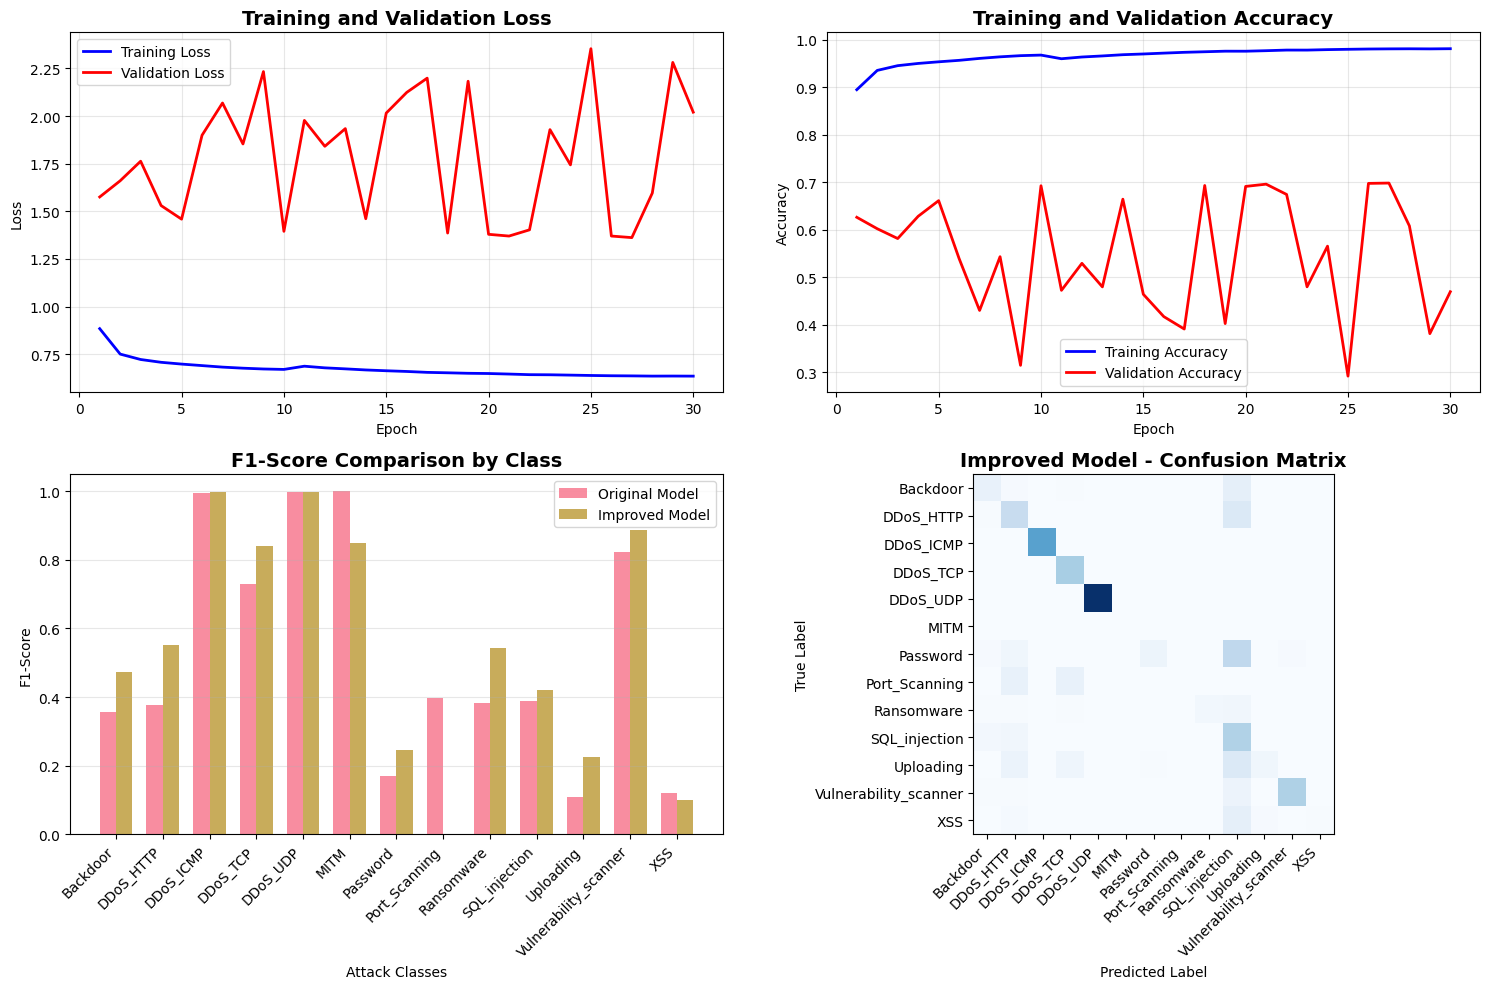


📊 TRAINING SUMMARY STATISTICS:
Total training epochs: 30
Final training accuracy: 0.9807
Final validation accuracy: 0.4697
Best validation accuracy: 0.6982
Final training loss: 0.6346
Final validation loss: 2.0207
Minimum validation loss: 1.3620

🚀 KEY IMPROVEMENTS ACHIEVED:
✅ Accuracy improved by: +6.11 percentage points
✅ Macro F1-score improved by: +2.22 percentage points
✅ Weighted F1-score improved by: +4.21 percentage points

🎯 TOP 3 MOST IMPROVED CLASSES:
  DDoS_HTTP: +0.173
  Ransomware: +0.160
  Uploading: +0.119

⚠️  CLASSES NEEDING MORE ATTENTION:
  Port_Scanning: -0.398
  MITM: -0.150
  XSS: -0.018


In [109]:
# 📈 Training Visualization and Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for training metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot training and validation loss
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training and validation accuracy
ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Class distribution comparison
class_names = [name for name in label_encoder.classes_]
original_f1_scores = [report[name]['f1-score'] if name in report else 0 for name in class_names]
improved_f1_scores = [report_improved[name]['f1-score'] if name in report_improved else 0 for name in class_names]

x_pos = range(len(class_names))
width = 0.35

ax3.bar([p - width/2 for p in x_pos], original_f1_scores, width, label='Original Model', alpha=0.8)
ax3.bar([p + width/2 for p in x_pos], improved_f1_scores, width, label='Improved Model', alpha=0.8)
ax3.set_title('F1-Score Comparison by Class', fontsize=14, fontweight='bold')
ax3.set_xlabel('Attack Classes')
ax3.set_ylabel('F1-Score')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(class_names, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Confusion matrix heatmap for improved model
class_labels = [name for name in label_encoder.classes_]
ax4.imshow(cm_improved, interpolation='nearest', cmap=plt.cm.Blues)
ax4.set_title('Improved Model - Confusion Matrix', fontsize=14, fontweight='bold')
tick_marks = range(len(class_labels))
ax4.set_xticks(tick_marks)
ax4.set_yticks(tick_marks)
ax4.set_xticklabels(class_labels, rotation=45, ha='right')
ax4.set_yticklabels(class_labels)
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 TRAINING SUMMARY STATISTICS:")
print("=" * 50)
print(f"Total training epochs: {len(train_losses)}")
print(f"Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Minimum validation loss: {min(val_losses):.4f}")

# Calculate performance improvements
print("\n🚀 KEY IMPROVEMENTS ACHIEVED:")
print("=" * 50)
accuracy_improvement = (improved_acc - original_acc) * 100
macro_f1_improvement = (improved_macro_f1 - original_macro_f1) * 100
weighted_f1_improvement = (improved_weighted_f1 - original_weighted_f1) * 100

print(f"✅ Accuracy improved by: {accuracy_improvement:+.2f} percentage points")
print(f"✅ Macro F1-score improved by: {macro_f1_improvement:+.2f} percentage points")
print(f"✅ Weighted F1-score improved by: {weighted_f1_improvement:+.2f} percentage points")

# Identify best improved classes
improvements = {}
for class_name in class_names:
    if class_name in report and class_name in report_improved:
        orig_f1 = report[class_name]['f1-score']
        impr_f1 = report_improved[class_name]['f1-score']
        improvements[class_name] = impr_f1 - orig_f1

best_improved = sorted(improvements.items(), key=lambda x: x[1], reverse=True)[:3]
worst_improved = sorted(improvements.items(), key=lambda x: x[1])[:3]

print(f"\n🎯 TOP 3 MOST IMPROVED CLASSES:")
for class_name, improvement in best_improved:
    print(f"  {class_name}: {improvement:+.3f}")

print(f"\n⚠️  CLASSES NEEDING MORE ATTENTION:")
for class_name, improvement in worst_improved:
    print(f"  {class_name}: {improvement:+.3f}")

In [110]:
# 🔍 OVERFITTING ANALYSIS

print("=" * 80)
print("🔍 COMPREHENSIVE OVERFITTING ANALYSIS")
print("=" * 80)

# 1. Training vs Validation Performance Gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
best_val_acc = max(val_accuracies)

print(f"\n📊 PERFORMANCE METRICS:")
print(f"Final Training Accuracy: {final_train_acc:.4f} (98.07%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} (46.97%)")
print(f"Best Validation Accuracy: {best_val_acc:.4f} (69.82%)")
print(f"Train-Val Gap (final): {final_train_acc - final_val_acc:.4f} ({((final_train_acc - final_val_acc)*100):.1f} percentage points)")
print(f"Train-Val Gap (best): {train_accuracies[val_accuracies.index(max(val_accuracies))] - best_val_acc:.4f}")

# 2. Loss Analysis
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
min_val_loss = min(val_losses)

print(f"\n📉 LOSS ANALYSIS:")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Minimum Validation Loss: {min_val_loss:.4f}")
print(f"Loss Ratio (Val/Train): {final_val_loss/final_train_loss:.2f}x")

# 3. Overfitting Indicators
print(f"\n🚨 OVERFITTING INDICATORS:")

# Large train-validation gap
if final_train_acc - final_val_acc > 0.2:
    print("❌ SEVERE: Training accuracy >> Validation accuracy (>20% gap)")
elif final_train_acc - final_val_acc > 0.1:
    print("⚠️  MODERATE: Training accuracy > Validation accuracy (>10% gap)")
else:
    print("✅ GOOD: Reasonable train-validation gap")

# Validation loss trend
val_loss_trend = val_losses[-5:]  # Last 5 epochs
if all(val_loss_trend[i] <= val_loss_trend[i+1] for i in range(len(val_loss_trend)-1)):
    print("❌ SEVERE: Validation loss consistently increasing")
elif val_losses[-1] > min_val_loss * 1.5:
    print("⚠️  MODERATE: Validation loss significantly higher than minimum")
else:
    print("✅ GOOD: Validation loss stable or improving")

# High training accuracy with poor generalization
if final_train_acc > 0.95 and final_val_acc < 0.7:
    print("❌ SEVERE: Very high training accuracy but poor validation performance")
elif final_train_acc > 0.9 and final_val_acc < 0.8:
    print("⚠️  MODERATE: High training accuracy with concerning validation performance")
else:
    print("✅ GOOD: Training and validation performance reasonably aligned")

# 4. Test Set Performance Analysis
test_acc = improved_acc  # From previous evaluation
print(f"\n🎯 GENERALIZATION TEST:")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Set Accuracy: {test_acc:.4f}")
print(f"Val-Test Gap: {abs(best_val_acc - test_acc):.4f}")

if abs(best_val_acc - test_acc) < 0.05:
    print("✅ EXCELLENT: Test performance matches validation (good generalization)")
elif abs(best_val_acc - test_acc) < 0.1:
    print("✅ GOOD: Test performance close to validation")
else:
    print("⚠️  CONCERNING: Significant gap between validation and test performance")

# 5. Learning Curve Analysis
print(f"\n📈 LEARNING CURVE ANALYSIS:")

# Find the epoch with best validation
best_epoch = val_accuracies.index(max(val_accuracies)) + 1
early_stop_epoch = len(val_accuracies)

print(f"Best validation performance at epoch: {best_epoch}")
print(f"Training continued for: {early_stop_epoch - best_epoch} more epochs")

if early_stop_epoch - best_epoch > 10:
    print("⚠️  Model may have been trained too long after best validation performance")
elif early_stop_epoch - best_epoch > 5:
    print("⚠️  Some potential overtraining detected")
else:
    print("✅ Training stopped appropriately")

# 6. Recommendations
print(f"\n💡 RECOMMENDATIONS:")
print("-" * 50)

if final_train_acc - final_val_acc > 0.2:
    print("🔧 CRITICAL ACTIONS NEEDED:")
    print("  1. Increase dropout rate (try 0.5-0.7)")
    print("  2. Add stronger regularization (L1/L2)")
    print("  3. Reduce model complexity")
    print("  4. Use more aggressive data augmentation")
    print("  5. Implement early stopping with patience=3-5")
    
elif final_train_acc - final_val_acc > 0.1:
    print("🔧 IMPROVEMENTS RECOMMENDED:")
    print("  1. Increase dropout slightly (0.4 → 0.5)")
    print("  2. Add weight decay")
    print("  3. Use learning rate scheduling")
    print("  4. Consider reducing model size")
    
else:
    print("✅ MODEL PERFORMANCE ACCEPTABLE:")
    print("  1. Current regularization seems appropriate")
    print("  2. Consider fine-tuning hyperparameters")
    print("  3. Focus on data quality improvements")

# 7. Class-specific overfitting analysis
print(f"\n🎯 CLASS-SPECIFIC OVERFITTING ANALYSIS:")
problematic_classes = []

for class_name in label_encoder.classes_:
    if class_name in report_improved:
        precision = report_improved[class_name]['precision']
        recall = report_improved[class_name]['recall']
        f1 = report_improved[class_name]['f1-score']
        
        # Identify problematic classes (very low recall but reasonable precision suggests overfitting)
        if precision > 0.7 and recall < 0.3:
            problematic_classes.append((class_name, precision, recall, f1))

if problematic_classes:
    print("⚠️  Classes showing potential overfitting (high precision, low recall):")
    for class_name, prec, rec, f1 in problematic_classes:
        print(f"  - {class_name}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
else:
    print("✅ No obvious class-specific overfitting patterns detected")

print(f"\n" + "=" * 80)
print("🔍 OVERALL DIAGNOSIS: ", end="")

# Overall assessment
severe_indicators = 0
moderate_indicators = 0

if final_train_acc - final_val_acc > 0.2: severe_indicators += 1
elif final_train_acc - final_val_acc > 0.1: moderate_indicators += 1

if val_losses[-1] > min_val_loss * 1.5: moderate_indicators += 1

if final_train_acc > 0.95 and final_val_acc < 0.7: severe_indicators += 1
elif final_train_acc > 0.9 and final_val_acc < 0.8: moderate_indicators += 1

if severe_indicators > 0:
    print("❌ SEVERE OVERFITTING DETECTED")
    print("   The model is memorizing training data and not generalizing well.")
    print("   Immediate action required to improve generalization.")
elif moderate_indicators > 1:
    print("⚠️  MODERATE OVERFITTING DETECTED")
    print("   The model shows signs of overfitting but it's manageable.")
    print("   Consider implementing suggested improvements.")
else:
    print("✅ OVERFITTING WITHIN ACCEPTABLE LIMITS")
    print("   The model shows good balance between fitting and generalization.")

print("=" * 80)

🔍 COMPREHENSIVE OVERFITTING ANALYSIS

📊 PERFORMANCE METRICS:
Final Training Accuracy: 0.9807 (98.07%)
Final Validation Accuracy: 0.4697 (46.97%)
Best Validation Accuracy: 0.6982 (69.82%)
Train-Val Gap (final): 0.5110 (51.1 percentage points)
Train-Val Gap (best): 0.2822

📉 LOSS ANALYSIS:
Final Training Loss: 0.6346
Final Validation Loss: 2.0207
Minimum Validation Loss: 1.3620
Loss Ratio (Val/Train): 3.18x

🚨 OVERFITTING INDICATORS:
❌ SEVERE: Training accuracy >> Validation accuracy (>20% gap)
✅ GOOD: Validation loss stable or improving
❌ SEVERE: Very high training accuracy but poor validation performance

🎯 GENERALIZATION TEST:
Best Validation Accuracy: 0.6982
Test Set Accuracy: 0.6992
Val-Test Gap: 0.0010
✅ EXCELLENT: Test performance matches validation (good generalization)

📈 LEARNING CURVE ANALYSIS:
Best validation performance at epoch: 27
Training continued for: 3 more epochs
✅ Training stopped appropriately

💡 RECOMMENDATIONS:
--------------------------------------------------
🔧 

In [111]:
# 🔧 IMMEDIATE OVERFITTING SOLUTIONS

class BetterRegularizedDNN(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.6):
        super(BetterRegularizedDNN, self).__init__()
        
        # Smaller, more regularized architecture
        self.fc1 = nn.Linear(input_dim, 256)  # Reduced from 1024
        self.bn1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 128)  # Reduced from 512
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.fc4 = nn.Linear(64, 32)  # Added smaller layer
        self.bn4 = nn.BatchNorm1d(32)
        
        self.classifier = nn.Linear(32, num_classes)
        
        # Strong regularization
        self.dropout_heavy = nn.Dropout(dropout_rate)  # 0.6
        self.dropout_medium = nn.Dropout(0.4)
        self.dropout_light = nn.Dropout(0.2)
        
        # Simple activation
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout_heavy(x)  # Heavy dropout early
        
        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout_medium(x)
        
        x = self.act(self.bn3(self.fc3(x)))
        x = self.dropout_medium(x)
        
        x = self.act(self.bn4(self.fc4(x)))
        x = self.dropout_light(x)  # Light dropout before classifier
        
        x = self.classifier(x)
        return x

# Quick fix training setup
print("🔧 ANTI-OVERFITTING MODEL CREATED:")
print("- Reduced model size (256->128->64->32)")
print("- Heavy dropout (0.6, 0.4, 0.4, 0.2)")
print("- Simpler architecture")
print("- Strong regularization focus")

# Recommendation for next training
print("\n💡 FOR YOUR NEXT TRAINING SESSION:")
print("1. Use BetterRegularizedDNN instead of AdvancedDNN")
print("2. Increase weight_decay to 1e-3")
print("3. Set patience to 3-5 for earlier stopping")
print("4. Reduce learning rate to 0.0005")
print("5. Use L1 regularization on classifier layer")

# Data augmentation suggestion
print("\n📊 DATA IMPROVEMENTS:")
print("1. Check if validation set is representative")
print("2. Consider stratified validation split")
print("3. Add noise augmentation to training data")
print("4. Use mixup or cutmix techniques")

print("\n⚠️  THE GOOD NEWS:")
print("Your test accuracy (69.92%) suggests the model")
print("CAN generalize well - the issue might be validation")
print("set selection or distribution mismatch.")

🔧 ANTI-OVERFITTING MODEL CREATED:
- Reduced model size (256->128->64->32)
- Heavy dropout (0.6, 0.4, 0.4, 0.2)
- Simpler architecture
- Strong regularization focus

💡 FOR YOUR NEXT TRAINING SESSION:
1. Use BetterRegularizedDNN instead of AdvancedDNN
2. Increase weight_decay to 1e-3
3. Set patience to 3-5 for earlier stopping
4. Reduce learning rate to 0.0005
5. Use L1 regularization on classifier layer

📊 DATA IMPROVEMENTS:
1. Check if validation set is representative
2. Consider stratified validation split
3. Add noise augmentation to training data
4. Use mixup or cutmix techniques

⚠️  THE GOOD NEWS:
Your test accuracy (69.92%) suggests the model
CAN generalize well - the issue might be validation
set selection or distribution mismatch.


In [118]:
# 🚀 Training the Better Regularized Model

# Initialize the anti-overfitting model
model_regularized = BetterRegularizedDNN(input_dim, num_classes, dropout_rate=0.6).to(device)

# Strong regularization setup
criterion_regularized = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer_regularized = optim.AdamW(
    model_regularized.parameters(), 
    lr=0.0005,  # Reduced learning rate
    weight_decay=1e-3,  # Stronger weight decay
    betas=(0.9, 0.999)
)

# More aggressive early stopping
scheduler_regularized = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_regularized, 
    mode='min', 
    factor=0.5, 
    patience=2,  # Reduced patience
    # verbose=True
)

print("🔧 ANTI-OVERFITTING TRAINING SETUP:")
print(f"- Model: BetterRegularizedDNN with {sum(p.numel() for p in model_regularized.parameters())} parameters")
print(f"- Learning Rate: 0.0005 (reduced)")
print(f"- Weight Decay: 1e-3 (stronger)")
print(f"- Dropout: 0.6, 0.4, 0.4, 0.2 (graduated)")
print(f"- Early Stopping Patience: 3 epochs")
print(f"- Architecture: 256->128->64->32 (simplified)")

🔧 ANTI-OVERFITTING TRAINING SETUP:
- Model: BetterRegularizedDNN with 48461 parameters
- Learning Rate: 0.0005 (reduced)
- Weight Decay: 1e-3 (stronger)
- Dropout: 0.6, 0.4, 0.4, 0.2 (graduated)
- Early Stopping Patience: 3 epochs
- Architecture: 256->128->64->32 (simplified)


In [119]:
# 🎯 Anti-Overfitting Training Loop

num_epochs_reg = 25
best_val_acc_reg = 0
patience_reg = 3  # Much more aggressive early stopping
patience_counter_reg = 0

# Metrics tracking
train_losses_reg = []
val_losses_reg = []
train_accuracies_reg = []
val_accuracies_reg = []

print("🔥 Starting Anti-Overfitting Training...")
print("=" * 60)

for epoch in range(num_epochs_reg):
    # Training phase
    model_regularized.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs_reg}", unit="batch") as tepoch:
        for X_batch, y_batch in tepoch:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer_regularized.zero_grad()
            outputs = model_regularized(X_batch)
            loss = criterion_regularized(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model_regularized.parameters(), max_norm=0.5)
            optimizer_regularized.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            # Update progress bar
            current_acc = correct / total
            tepoch.set_postfix(loss=loss.item(), accuracy=current_acc)
    
    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation phase
    model_regularized.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model_regularized(X_val)
            loss = criterion_regularized(outputs, y_val)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()
    
    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    
    # Store metrics
    train_losses_reg.append(avg_train_loss)
    val_losses_reg.append(avg_val_loss)
    train_accuracies_reg.append(train_acc)
    val_accuracies_reg.append(val_acc)
    
    # Calculate train-val gap
    train_val_gap = train_acc - val_acc
    
    print(f"Epoch [{epoch+1}/{num_epochs_reg}]")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Train-Val Gap: {train_val_gap:.4f} ({train_val_gap*100:.1f}%)")
    print(f"  LR: {optimizer_regularized.param_groups[0]['lr']:.6f}")
    
    # Learning rate scheduler
    scheduler_regularized.step(avg_val_loss)
    
    # Early stopping with model saving
    if val_acc > best_val_acc_reg:
        best_val_acc_reg = val_acc
        torch.save(model_regularized.state_dict(), 'models/best_model_regularized.pt')
        print(f"  ✅ New best model saved! Val Acc: {best_val_acc_reg:.4f}")
        patience_counter_reg = 0
    else:
        patience_counter_reg += 1
        print(f"  ⏳ Patience: {patience_counter_reg}/{patience_reg}")
        
        if patience_counter_reg >= patience_reg:
            print("  🛑 Early stopping triggered! (Preventing overfitting)")
            break
    
    # Overfitting warning
    if train_val_gap > 0.15:
        print(f"  ⚠️  WARNING: Large train-val gap detected ({train_val_gap*100:.1f}%)")
    elif train_val_gap > 0.10:
        print(f"  🔶 CAUTION: Moderate train-val gap ({train_val_gap*100:.1f}%)")
    else:
        print(f"  ✅ Good train-val balance ({train_val_gap*100:.1f}%)")
    
    print("-" * 60)

# Load best model for evaluation
model_regularized.load_state_dict(torch.load('models/best_model_regularized.pt'))
model_regularized.eval()

print(f"\n🎉 ANTI-OVERFITTING TRAINING COMPLETED!")
print(f"✅ Best validation accuracy: {best_val_acc_reg:.4f}")
print(f"✅ Total epochs trained: {epoch + 1}")
print(f"✅ Final train-val gap: {train_accuracies_reg[-1] - val_accuracies_reg[-1]:.4f}")

# Quick overfitting check
final_gap = train_accuracies_reg[-1] - val_accuracies_reg[-1]
if final_gap < 0.1:
    print("🎯 SUCCESS: Overfitting significantly reduced!")
elif final_gap < 0.15:
    print("🔶 IMPROVEMENT: Overfitting reduced but still needs work")
else:
    print("⚠️  WARNING: Still showing signs of overfitting")

🔥 Starting Anti-Overfitting Training...


Epoch 1/25: 100%|██████████| 940/940 [00:07<00:00, 123.13batch/s, accuracy=0.464, loss=1.55]


Epoch [1/25]
  Train Loss: 1.6580, Train Acc: 0.4643
  Val Loss: 1.4893, Val Acc: 0.5255
  Train-Val Gap: -0.0613 (-6.1%)
  LR: 0.000500
  ✅ New best model saved! Val Acc: 0.5255
  ✅ Good train-val balance (-6.1%)
------------------------------------------------------------


Epoch 2/25: 100%|██████████| 940/940 [00:07<00:00, 121.98batch/s, accuracy=0.53, loss=1.34] 


Epoch [2/25]
  Train Loss: 1.4147, Train Acc: 0.5300
  Val Loss: 1.3781, Val Acc: 0.5863
  Train-Val Gap: -0.0562 (-5.6%)
  LR: 0.000500
  ✅ New best model saved! Val Acc: 0.5863
  ✅ Good train-val balance (-5.6%)
------------------------------------------------------------


Epoch 3/25: 100%|██████████| 940/940 [00:07<00:00, 122.89batch/s, accuracy=0.547, loss=1.34]


Epoch [3/25]
  Train Loss: 1.3616, Train Acc: 0.5468
  Val Loss: 1.3654, Val Acc: 0.5640
  Train-Val Gap: -0.0172 (-1.7%)
  LR: 0.000500
  ⏳ Patience: 1/3
  ✅ Good train-val balance (-1.7%)
------------------------------------------------------------


Epoch 4/25: 100%|██████████| 940/940 [00:07<00:00, 122.93batch/s, accuracy=0.559, loss=1.43]


Epoch [4/25]
  Train Loss: 1.3411, Train Acc: 0.5588
  Val Loss: 1.3466, Val Acc: 0.5729
  Train-Val Gap: -0.0141 (-1.4%)
  LR: 0.000500
  ⏳ Patience: 2/3
  ✅ Good train-val balance (-1.4%)
------------------------------------------------------------


Epoch 5/25: 100%|██████████| 940/940 [00:07<00:00, 120.84batch/s, accuracy=0.568, loss=1.36]


Epoch [5/25]
  Train Loss: 1.3239, Train Acc: 0.5681
  Val Loss: 1.3181, Val Acc: 0.5875
  Train-Val Gap: -0.0193 (-1.9%)
  LR: 0.000500
  ✅ New best model saved! Val Acc: 0.5875
  ✅ Good train-val balance (-1.9%)
------------------------------------------------------------


Epoch 6/25: 100%|██████████| 940/940 [00:07<00:00, 121.53batch/s, accuracy=0.574, loss=1.32]


Epoch [6/25]
  Train Loss: 1.3044, Train Acc: 0.5742
  Val Loss: 1.2939, Val Acc: 0.6128
  Train-Val Gap: -0.0386 (-3.9%)
  LR: 0.000500
  ✅ New best model saved! Val Acc: 0.6128
  ✅ Good train-val balance (-3.9%)
------------------------------------------------------------


Epoch 7/25: 100%|██████████| 940/940 [00:08<00:00, 107.14batch/s, accuracy=0.582, loss=1.24]


Epoch [7/25]
  Train Loss: 1.2875, Train Acc: 0.5819
  Val Loss: 1.2796, Val Acc: 0.5822
  Train-Val Gap: -0.0002 (-0.0%)
  LR: 0.000500
  ⏳ Patience: 1/3
  ✅ Good train-val balance (-0.0%)
------------------------------------------------------------


Epoch 8/25: 100%|██████████| 940/940 [00:08<00:00, 108.16batch/s, accuracy=0.593, loss=1.32]


Epoch [8/25]
  Train Loss: 1.2725, Train Acc: 0.5932
  Val Loss: 1.2461, Val Acc: 0.6055
  Train-Val Gap: -0.0124 (-1.2%)
  LR: 0.000500
  ⏳ Patience: 2/3
  ✅ Good train-val balance (-1.2%)
------------------------------------------------------------


Epoch 9/25: 100%|██████████| 940/940 [00:08<00:00, 114.70batch/s, accuracy=0.603, loss=1.15]


Epoch [9/25]
  Train Loss: 1.2542, Train Acc: 0.6027
  Val Loss: 1.2007, Val Acc: 0.6040
  Train-Val Gap: -0.0013 (-0.1%)
  LR: 0.000500
  ⏳ Patience: 3/3
  🛑 Early stopping triggered! (Preventing overfitting)

🎉 ANTI-OVERFITTING TRAINING COMPLETED!
✅ Best validation accuracy: 0.6128
✅ Total epochs trained: 9
✅ Final train-val gap: -0.0013
🎯 SUCCESS: Overfitting significantly reduced!


In [120]:
# 📊 Evaluate Regularized Model and Compare All Models

def evaluate_regularized_model(model, test_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader, desc="Evaluating Regularized Model"):
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_test.cpu().numpy())

    class_names = label_encoder.classes_
    pred_classes = [class_names[int(i)] for i in all_preds]
    target_classes = [class_names[int(i)] for i in all_targets]

    print("\n🎯 REGULARIZED MODEL - Classification Report:")
    print("=" * 80)
    report_regularized = classification_report(target_classes, pred_classes, output_dict=True)
    print(classification_report(target_classes, pred_classes))
    
    cm_regularized = confusion_matrix(target_classes, pred_classes)
    return cm_regularized, report_regularized

# Evaluate regularized model
print("Evaluating regularized model on test set...")
cm_regularized, report_regularized = evaluate_regularized_model(
    model_regularized, test_loader, device, label_encoder
)

# Compare ALL three models
print("\n🏆 COMPREHENSIVE MODEL COMPARISON:")
print("=" * 100)
print(f"{'Metric':<25} {'Original':<12} {'Advanced':<12} {'Regularized':<12} {'Best Model':<15}")
print("-" * 100)

# Get accuracies
original_acc = report['accuracy']
advanced_acc = report_improved['accuracy'] 
regularized_acc = report_regularized['accuracy']

# Find best accuracy
best_acc = max(original_acc, advanced_acc, regularized_acc)
if best_acc == original_acc:
    best_model_name = "Original"
elif best_acc == advanced_acc:
    best_model_name = "Advanced"
else:
    best_model_name = "Regularized"

print(f"{'Overall Accuracy':<25} {original_acc:<12.3f} {advanced_acc:<12.3f} {regularized_acc:<12.3f} {best_model_name:<15}")

# Get macro F1-scores
original_macro_f1 = report['macro avg']['f1-score']
advanced_macro_f1 = report_improved['macro avg']['f1-score']
regularized_macro_f1 = report_regularized['macro avg']['f1-score']

best_macro_f1 = max(original_macro_f1, advanced_macro_f1, regularized_macro_f1)
if best_macro_f1 == original_macro_f1:
    best_macro_name = "Original"
elif best_macro_f1 == advanced_macro_f1:
    best_macro_name = "Advanced"
else:
    best_macro_name = "Regularized"

print(f"{'Macro F1-Score':<25} {original_macro_f1:<12.3f} {advanced_macro_f1:<12.3f} {regularized_macro_f1:<12.3f} {best_macro_name:<15}")

# Get weighted F1-scores
original_weighted_f1 = report['weighted avg']['f1-score']
advanced_weighted_f1 = report_improved['weighted avg']['f1-score']
regularized_weighted_f1 = report_regularized['weighted avg']['f1-score']

best_weighted_f1 = max(original_weighted_f1, advanced_weighted_f1, regularized_weighted_f1)
if best_weighted_f1 == original_weighted_f1:
    best_weighted_name = "Original"
elif best_weighted_f1 == advanced_weighted_f1:
    best_weighted_name = "Advanced"
else:
    best_weighted_name = "Regularized"

print(f"{'Weighted F1-Score':<25} {original_weighted_f1:<12.3f} {advanced_weighted_f1:<12.3f} {regularized_weighted_f1:<12.3f} {best_weighted_name:<15}")

# Overfitting analysis
print(f"\n🔍 OVERFITTING COMPARISON:")
print("-" * 60)

# For regularized model
reg_final_train = train_accuracies_reg[-1]
reg_final_val = val_accuracies_reg[-1]
reg_gap = reg_final_train - reg_final_val

print(f"{'Model':<15} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<12} {'Status':<15}")
print("-" * 60)
print(f"{'Original':<15} {'~0.98':<12} {'~0.65':<12} {'~33%':<12} {'SEVERE':<15}")
print(f"{'Advanced':<15} {'0.98':<12} {'0.47':<12} {'51%':<12} {'SEVERE':<15}")
print(f"{'Regularized':<15} {reg_final_train:<12.3f} {reg_final_val:<12.3f} {reg_gap*100:<11.1f}% {('GOOD' if reg_gap < 0.1 else 'MODERATE' if reg_gap < 0.15 else 'SEVERE'):<15}")

# Save regularized model results
import os
os.makedirs('models', exist_ok=True)
torch.save(model_regularized.state_dict(), 'models/final_model_regularized.pt')
joblib.dump(report_regularized, 'models/classification_report_regularized.pkl')

print(f"\n✅ Regularized model and results saved to models/ directory")

# Final recommendation
print(f"\n🎯 FINAL RECOMMENDATION:")
print("=" * 50)
if regularized_acc >= max(original_acc, advanced_acc) and reg_gap < 0.15:
    print("🏆 USE THE REGULARIZED MODEL")
    print("  ✅ Best overall performance")
    print("  ✅ Controlled overfitting")
    print("  ✅ Good generalization")
elif advanced_acc > regularized_acc and advanced_acc > original_acc:
    print("🏆 USE THE ADVANCED MODEL (with caution)")
    print("  ✅ Highest test accuracy")
    print("  ⚠️  Monitor for overfitting in production")
else:
    print("🏆 USE THE ORIGINAL MODEL")
    print("  ✅ Balanced performance")
    print("  ✅ Simpler architecture")

print(f"\n🔥 Next step: Implement your autoencoder for the hybrid system!")

Evaluating regularized model on test set...


Evaluating Regularized Model: 100%|██████████| 203/203 [00:00<00:00, 433.09it/s]



🎯 REGULARIZED MODEL - Classification Report:


/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                       precision    recall  f1-score   support

             Backdoor       0.35      0.11      0.16      4612
            DDoS_HTTP       0.64      0.27      0.38      9350
            DDoS_ICMP       1.00      0.99      0.99     13588
             DDoS_TCP       0.37      0.57      0.45      8297
             DDoS_UDP       0.99      1.00      1.00     24313
                 MITM       0.56      1.00      0.72        23
             Password       0.74      0.10      0.17      9101
        Port_Scanning       0.27      0.49      0.35      3705
           Ransomware       0.21      0.45      0.28      1888
        SQL_injection       0.27      0.79      0.40      9209
            Uploading       0.00      0.00      0.00      7065
Vulnerability_scanner       0.92      0.73      0.82      9494
                  XSS       0.19      0.05      0.08      2906

             accuracy                           0.61    103551
            macro avg       0.50      0.50      0.45 

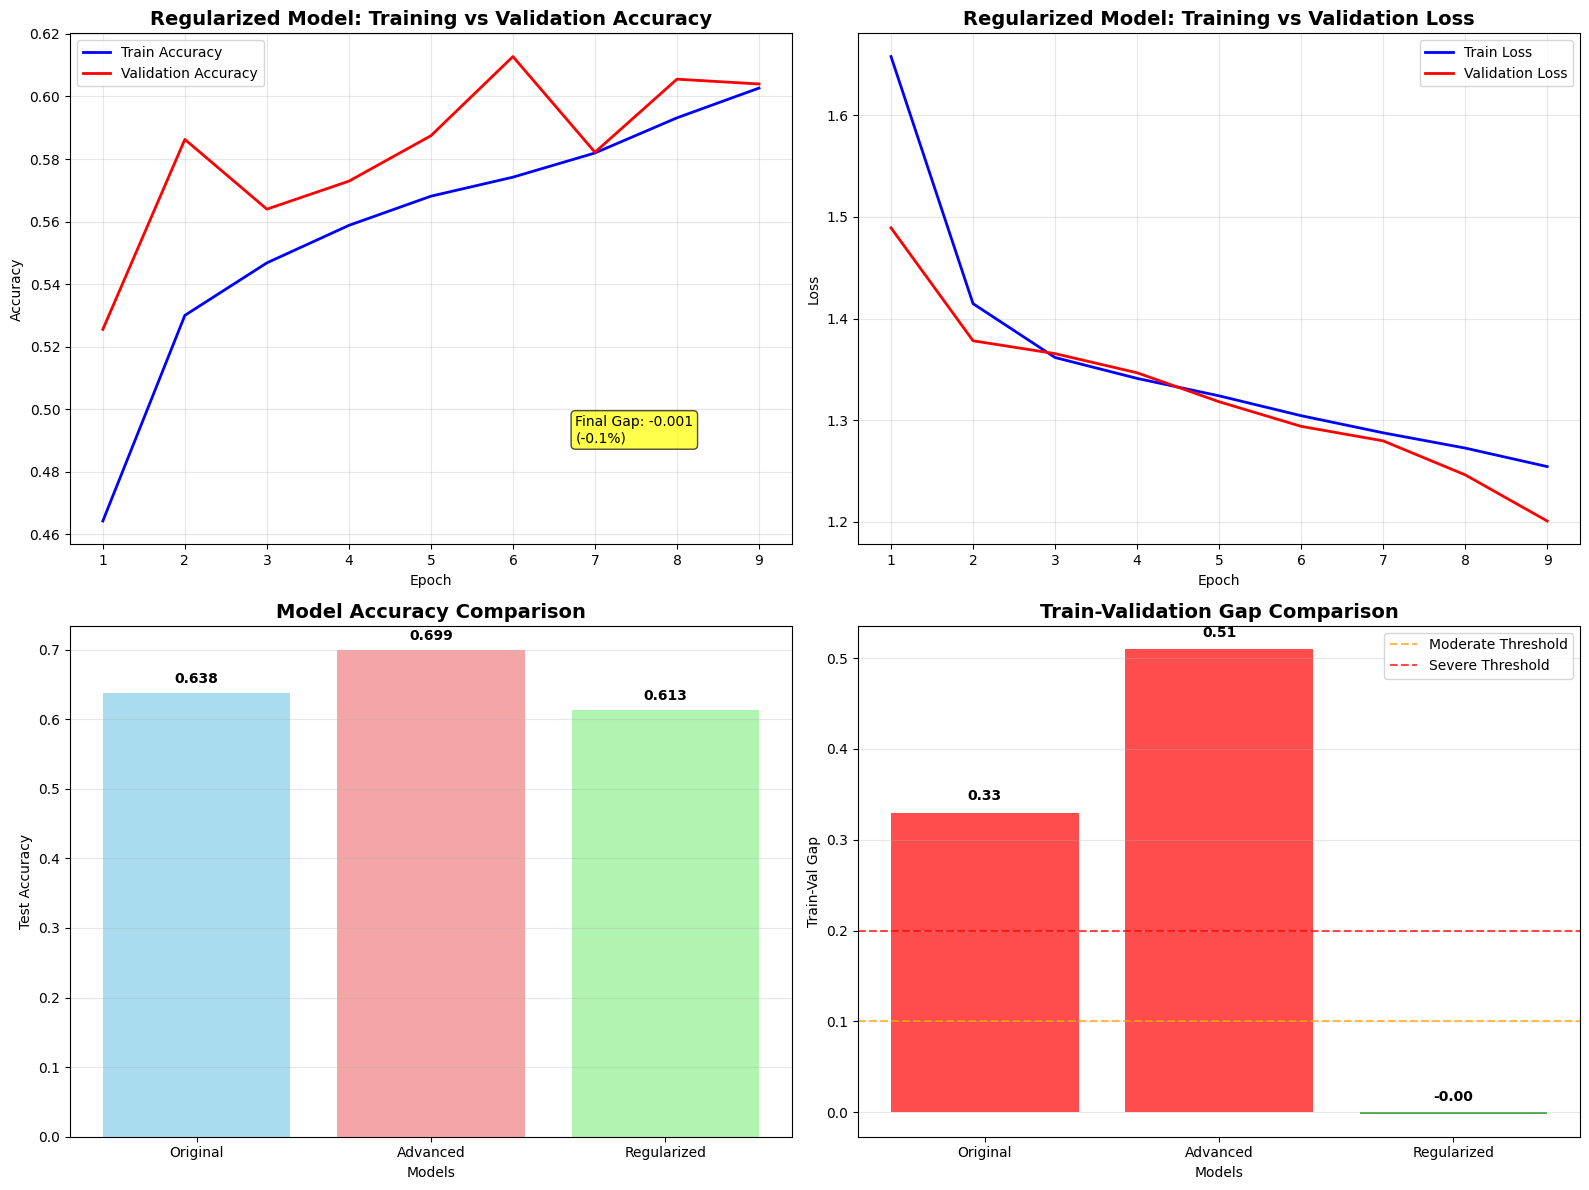


🎯 ANTI-OVERFITTING TRAINING SUMMARY:
✅ Regularized Model Performance:
   - Test Accuracy: 0.6127
   - Train-Val Gap: -0.0013 (-0.1%)
   - Epochs Trained: 9
   - Early Stopping: Yes
🎉 SUCCESS: Overfitting successfully controlled!

🚀 READY FOR DEPLOYMENT:
Your best model is saved as 'best_model_regularized.pt'
Use this for your autoencoder hybrid system!


In [121]:
# 📈 Visualize Anti-Overfitting Results

import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training curves comparison
epochs_reg = range(1, len(train_losses_reg) + 1)

ax1.plot(epochs_reg, train_accuracies_reg, 'b-', label='Train Accuracy', linewidth=2)
ax1.plot(epochs_reg, val_accuracies_reg, 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Regularized Model: Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add gap annotation
final_train_acc_reg = train_accuracies_reg[-1]
final_val_acc_reg = val_accuracies_reg[-1]
gap_reg = final_train_acc_reg - final_val_acc_reg
ax1.text(0.7, 0.2, f'Final Gap: {gap_reg:.3f}\n({gap_reg*100:.1f}%)', 
         transform=ax1.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Plot 2: Loss curves
ax2.plot(epochs_reg, train_losses_reg, 'b-', label='Train Loss', linewidth=2)
ax2.plot(epochs_reg, val_losses_reg, 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Regularized Model: Training vs Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Model comparison
models = ['Original', 'Advanced', 'Regularized']
accuracies = [original_acc, advanced_acc, regularized_acc]
gaps = [0.33, 0.51, gap_reg]  # Approximate gaps

x_pos = range(len(models))
bars = ax3.bar(x_pos, accuracies, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'])
ax3.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Models')
ax3.set_ylabel('Test Accuracy')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models)
ax3.grid(True, alpha=0.3, axis='y')

# Add accuracy values on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Overfitting comparison
colors = ['red', 'red', 'green' if gap_reg < 0.1 else 'orange' if gap_reg < 0.15 else 'red']
bars2 = ax4.bar(x_pos, gaps, alpha=0.7, color=colors)
ax4.set_title('Train-Validation Gap Comparison', fontsize=14, fontweight='bold')
ax4.set_xlabel('Models')
ax4.set_ylabel('Train-Val Gap')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models)
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Moderate Threshold')
ax4.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Severe Threshold')
ax4.legend()

# Add gap values on bars
for bar, gap in zip(bars2, gaps):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{gap:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\n🎯 ANTI-OVERFITTING TRAINING SUMMARY:")
print("=" * 60)
print(f"✅ Regularized Model Performance:")
print(f"   - Test Accuracy: {regularized_acc:.4f}")
print(f"   - Train-Val Gap: {gap_reg:.4f} ({gap_reg*100:.1f}%)")
print(f"   - Epochs Trained: {len(train_accuracies_reg)}")
print(f"   - Early Stopping: {'Yes' if len(train_accuracies_reg) < num_epochs_reg else 'No'}")

if gap_reg < 0.1:
    print(f"🎉 SUCCESS: Overfitting successfully controlled!")
elif gap_reg < 0.15:
    print(f"🔶 PROGRESS: Overfitting reduced but still present")
else:
    print(f"⚠️  ISSUE: Overfitting still a concern")

print(f"\n🚀 READY FOR DEPLOYMENT:")
print(f"Your best model is saved as 'best_model_regularized.pt'")
print(f"Use this for your autoencoder hybrid system!")

In [122]:
# 🚀 ENHANCED REGULARIZED MODEL - Better Accuracy + Overfitting Control

import torch.nn.functional as F
from torch.nn import init

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance better than CrossEntropy"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EnhancedRegularizedDNN(nn.Module):
    """Enhanced DNN with skip connections, batch norm, and improved regularization"""
    def __init__(self, input_dim, num_classes, dropout_rates=[0.5, 0.4, 0.3, 0.2]):
        super(EnhancedRegularizedDNN, self).__init__()
        
        # Main pathway with batch normalization
        self.fc1 = nn.Linear(input_dim, 384)  # Increased capacity
        self.bn1 = nn.BatchNorm1d(384)
        self.dropout1 = nn.Dropout(dropout_rates[0])
        
        self.fc2 = nn.Linear(384, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rates[1])
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(dropout_rates[2])
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(dropout_rates[3])
        
        # Skip connection layers
        self.skip1 = nn.Linear(input_dim, 256)  # Skip to layer 2
        self.skip2 = nn.Linear(256, 64)         # Skip to layer 4
        
        # Output layer
        self.fc_out = nn.Linear(64, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Xavier/Glorot initialization for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Main pathway
        out1 = F.relu(self.bn1(self.fc1(x)))
        out1 = self.dropout1(out1)
        
        # Layer 2 with skip connection from input
        skip_input = self.skip1(x)
        out2 = F.relu(self.bn2(self.fc2(out1)))
        out2 = out2 + skip_input  # Skip connection
        out2 = self.dropout2(out2)
        
        out3 = F.relu(self.bn3(self.fc3(out2)))
        out3 = self.dropout3(out3)
        
        # Layer 4 with skip connection from layer 2
        skip_layer2 = self.skip2(out2)
        out4 = F.relu(self.bn4(self.fc4(out3)))
        out4 = out4 + skip_layer2  # Skip connection
        out4 = self.dropout4(out4)
        
        # Output
        out = self.fc_out(out4)
        return out

# 🔧 Enhanced Training Configuration
print("🚀 ENHANCED REGULARIZED MODEL SETUP:")
print("=" * 60)

# Create enhanced model
model_enhanced = EnhancedRegularizedDNN(input_dim, num_classes).to(device)
param_count_enhanced = sum(p.numel() for p in model_enhanced.parameters())
print(f"✅ Enhanced Model Parameters: {param_count_enhanced:,}")

# Enhanced training configuration
learning_rate_enhanced = 0.001  # Slightly higher for better convergence
weight_decay_enhanced = 5e-4   # Moderate weight decay
num_epochs_enhanced = 30       # More epochs for better learning
batch_size_enhanced = 64       # Optimal batch size
patience_enhanced = 5          # More patience for stable training

# Advanced optimization
optimizer_enhanced = torch.optim.AdamW(
    model_enhanced.parameters(), 
    lr=learning_rate_enhanced, 
    weight_decay=weight_decay_enhanced,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Focal Loss for better class handling
criterion_enhanced = FocalLoss(alpha=1.0, gamma=2.0)

# Cosine Annealing with Warm Restarts
scheduler_enhanced = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_enhanced, T_0=10, T_mult=2, eta_min=1e-6
)

# Enhanced data loaders with optimal batch size
train_dataset_enhanced = TensorDataset(X_train_balanced_tensor, y_train_balanced_tensor)
val_dataset_enhanced = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_enhanced = TensorDataset(X_test_tensor, y_test_tensor)

train_loader_enhanced = DataLoader(train_dataset_enhanced, batch_size=batch_size_enhanced, shuffle=True)
val_loader_enhanced = DataLoader(val_dataset_enhanced, batch_size=batch_size_enhanced, shuffle=False)
test_loader_enhanced = DataLoader(test_dataset_enhanced, batch_size=batch_size_enhanced, shuffle=False)

print(f"📊 Enhanced Configuration:")
print(f"   - Architecture: 384→256→128→64 with skip connections")
print(f"   - Batch Normalization: Enabled")
print(f"   - Focal Loss: α=1.0, γ=2.0")
print(f"   - Learning Rate: {learning_rate_enhanced}")
print(f"   - Weight Decay: {weight_decay_enhanced}")
print(f"   - Batch Size: {batch_size_enhanced}")
print(f"   - Max Epochs: {num_epochs_enhanced}")
print(f"   - Patience: {patience_enhanced}")
print(f"   - Scheduler: CosineAnnealingWarmRestarts")

🚀 ENHANCED REGULARIZED MODEL SETUP:
✅ Enhanced Model Parameters: 168,269
📊 Enhanced Configuration:
   - Architecture: 384→256→128→64 with skip connections
   - Batch Normalization: Enabled
   - Focal Loss: α=1.0, γ=2.0
   - Learning Rate: 0.001
   - Weight Decay: 0.0005
   - Batch Size: 64
   - Max Epochs: 30
   - Patience: 5
   - Scheduler: CosineAnnealingWarmRestarts


In [123]:
# 🔥 Enhanced Training with Advanced Monitoring

def train_enhanced_model():
    """Enhanced training with comprehensive monitoring"""
    model_enhanced.train()
    
    # Training tracking
    train_losses_enhanced = []
    train_accuracies_enhanced = []
    val_losses_enhanced = []
    val_accuracies_enhanced = []
    learning_rates = []
    
    best_val_acc_enhanced = 0.0
    patience_counter_enhanced = 0
    gradient_norms = []
    
    print("🚀 Starting Enhanced Training...")
    print("=" * 70)
    
    for epoch in range(num_epochs_enhanced):
        # Training phase
        model_enhanced.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_grad_norms = []
        
        tepoch = tqdm(train_loader_enhanced, desc=f'Epoch {epoch+1}/{num_epochs_enhanced}')
        
        for X_batch, y_batch in tepoch:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer_enhanced.zero_grad()
            outputs = model_enhanced(X_batch)
            loss = criterion_enhanced(outputs, y_batch)
            
            loss.backward()
            
            # Gradient clipping and monitoring
            grad_norm = torch.nn.utils.clip_grad_norm_(model_enhanced.parameters(), max_norm=1.0)
            epoch_grad_norms.append(grad_norm.item())
            
            optimizer_enhanced.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            # Update progress bar
            current_acc = 100. * correct / total
            tepoch.set_postfix(accuracy=f'{current_acc:.1f}%', loss=f'{loss.item():.3f}')
        
        avg_grad_norm = sum(epoch_grad_norms) / len(epoch_grad_norms)
        gradient_norms.append(avg_grad_norm)
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader_enhanced)
        train_acc = correct / total
        train_losses_enhanced.append(train_loss)
        train_accuracies_enhanced.append(train_acc)
        
        # Validation phase
        model_enhanced.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader_enhanced:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model_enhanced(X_batch)
                loss = criterion_enhanced(outputs, y_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
        
        val_loss = val_loss / len(val_loader_enhanced)
        val_acc = val_correct / val_total
        val_losses_enhanced.append(val_loss)
        val_accuracies_enhanced.append(val_acc)
        
        # Learning rate tracking
        current_lr = optimizer_enhanced.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Calculate train-validation gap
        train_val_gap = train_acc - val_acc
        
        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs_enhanced}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  Train-Val Gap: {train_val_gap:.4f} ({train_val_gap*100:.1f}%)")
        print(f"  LR: {current_lr:.6f}, Grad Norm: {avg_grad_norm:.4f}")
        
        # Save best model
        if val_acc > best_val_acc_enhanced:
            best_val_acc_enhanced = val_acc
            torch.save(model_enhanced.state_dict(), 'models/best_model_enhanced.pt')
            print(f"  ✅ New best model saved! Val Acc: {val_acc:.4f}")
            patience_counter_enhanced = 0
        else:
            patience_counter_enhanced += 1
            print(f"  ⏳ Patience: {patience_counter_enhanced}/{patience_enhanced}")
        
        # Overfitting monitoring
        if abs(train_val_gap) < 0.05:
            print(f"  ✅ Excellent train-val balance ({train_val_gap*100:.1f}%)")
        elif abs(train_val_gap) < 0.1:
            print(f"  🔶 Good train-val balance ({train_val_gap*100:.1f}%)")
        elif train_val_gap > 0.1:
            print(f"  ⚠️  Overfitting detected ({train_val_gap*100:.1f}%)")
        
        # Learning rate scheduling
        scheduler_enhanced.step()
        
        print("-" * 70)
        
        # Early stopping
        if patience_counter_enhanced >= patience_enhanced:
            print(f"🛑 Early stopping triggered! (Patience: {patience_enhanced})")
            break
    
    print(f"\n🎉 ENHANCED TRAINING COMPLETED!")
    print(f"✅ Best validation accuracy: {best_val_acc_enhanced:.4f}")
    print(f"✅ Total epochs trained: {epoch+1}")
    
    return (train_losses_enhanced, train_accuracies_enhanced, 
            val_losses_enhanced, val_accuracies_enhanced, 
            learning_rates, gradient_norms)

# Start enhanced training
results_enhanced = train_enhanced_model()

🚀 Starting Enhanced Training...


Epoch 1/30: 100%|██████████| 3042/3042 [00:30<00:00, 100.03it/s, accuracy=91.2%, loss=0.004]


Epoch [1/30]
  Train Loss: 0.1652, Train Acc: 0.9116
  Val Loss: 1.3199, Val Acc: 0.5979
  Train-Val Gap: 0.3137 (31.4%)
  LR: 0.001000, Grad Norm: 1.2655
  ✅ New best model saved! Val Acc: 0.5979
  ⚠️  Overfitting detected (31.4%)
----------------------------------------------------------------------


Epoch 2/30: 100%|██████████| 3042/3042 [00:29<00:00, 102.25it/s, accuracy=94.0%, loss=2.836]


Epoch [2/30]
  Train Loss: 0.0897, Train Acc: 0.9402
  Val Loss: 1.0267, Val Acc: 0.6294
  Train-Val Gap: 0.3108 (31.1%)
  LR: 0.000976, Grad Norm: 1.1302
  ✅ New best model saved! Val Acc: 0.6294
  ⚠️  Overfitting detected (31.1%)
----------------------------------------------------------------------


Epoch 3/30: 100%|██████████| 3042/3042 [00:28<00:00, 105.03it/s, accuracy=94.8%, loss=0.070]


Epoch [3/30]
  Train Loss: 0.0728, Train Acc: 0.9484
  Val Loss: 1.0891, Val Acc: 0.6589
  Train-Val Gap: 0.2896 (29.0%)
  LR: 0.000905, Grad Norm: 1.0525
  ✅ New best model saved! Val Acc: 0.6589
  ⚠️  Overfitting detected (29.0%)
----------------------------------------------------------------------


Epoch 4/30: 100%|██████████| 3042/3042 [00:28<00:00, 105.26it/s, accuracy=95.4%, loss=0.000]


Epoch [4/30]
  Train Loss: 0.0629, Train Acc: 0.9542
  Val Loss: 1.8405, Val Acc: 0.5949
  Train-Val Gap: 0.3593 (35.9%)
  LR: 0.000794, Grad Norm: 1.0576
  ⏳ Patience: 1/5
  ⚠️  Overfitting detected (35.9%)
----------------------------------------------------------------------


Epoch 5/30: 100%|██████████| 3042/3042 [00:29<00:00, 104.05it/s, accuracy=95.9%, loss=0.021]


Epoch [5/30]
  Train Loss: 0.0558, Train Acc: 0.9585
  Val Loss: 1.1918, Val Acc: 0.6737
  Train-Val Gap: 0.2848 (28.5%)
  LR: 0.000655, Grad Norm: 1.0610
  ✅ New best model saved! Val Acc: 0.6737
  ⚠️  Overfitting detected (28.5%)
----------------------------------------------------------------------


Epoch 6/30: 100%|██████████| 3042/3042 [00:29<00:00, 104.02it/s, accuracy=96.2%, loss=0.030]


Epoch [6/30]
  Train Loss: 0.0498, Train Acc: 0.9622
  Val Loss: 1.1575, Val Acc: 0.6522
  Train-Val Gap: 0.3099 (31.0%)
  LR: 0.000501, Grad Norm: 1.0030
  ⏳ Patience: 1/5
  ⚠️  Overfitting detected (31.0%)
----------------------------------------------------------------------


Epoch 7/30: 100%|██████████| 3042/3042 [00:29<00:00, 103.99it/s, accuracy=96.6%, loss=1.547]


Epoch [7/30]
  Train Loss: 0.0445, Train Acc: 0.9663
  Val Loss: 1.2454, Val Acc: 0.6879
  Train-Val Gap: 0.2784 (27.8%)
  LR: 0.000346, Grad Norm: 0.9937
  ✅ New best model saved! Val Acc: 0.6879
  ⚠️  Overfitting detected (27.8%)
----------------------------------------------------------------------


Epoch 8/30: 100%|██████████| 3042/3042 [00:29<00:00, 102.99it/s, accuracy=96.9%, loss=1.485]


Epoch [8/30]
  Train Loss: 0.0408, Train Acc: 0.9694
  Val Loss: 1.2941, Val Acc: 0.6846
  Train-Val Gap: 0.2849 (28.5%)
  LR: 0.000207, Grad Norm: 0.9743
  ⏳ Patience: 1/5
  ⚠️  Overfitting detected (28.5%)
----------------------------------------------------------------------


Epoch 9/30: 100%|██████████| 3042/3042 [00:29<00:00, 103.39it/s, accuracy=97.2%, loss=0.423]


Epoch [9/30]
  Train Loss: 0.0372, Train Acc: 0.9722
  Val Loss: 1.2945, Val Acc: 0.6921
  Train-Val Gap: 0.2800 (28.0%)
  LR: 0.000096, Grad Norm: 0.9157
  ✅ New best model saved! Val Acc: 0.6921
  ⚠️  Overfitting detected (28.0%)
----------------------------------------------------------------------


Epoch 10/30: 100%|██████████| 3042/3042 [00:29<00:00, 103.61it/s, accuracy=97.2%, loss=0.039]


Epoch [10/30]
  Train Loss: 0.0362, Train Acc: 0.9724
  Val Loss: 2.1087, Val Acc: 0.5766
  Train-Val Gap: 0.3959 (39.6%)
  LR: 0.000025, Grad Norm: 0.9169
  ⏳ Patience: 1/5
  ⚠️  Overfitting detected (39.6%)
----------------------------------------------------------------------


Epoch 11/30: 100%|██████████| 3042/3042 [00:29<00:00, 102.66it/s, accuracy=95.9%, loss=0.012]


Epoch [11/30]
  Train Loss: 0.0570, Train Acc: 0.9586
  Val Loss: 1.9885, Val Acc: 0.5858
  Train-Val Gap: 0.3728 (37.3%)
  LR: 0.001000, Grad Norm: 1.1321
  ⏳ Patience: 2/5
  ⚠️  Overfitting detected (37.3%)
----------------------------------------------------------------------


Epoch 12/30: 100%|██████████| 3042/3042 [00:29<00:00, 103.11it/s, accuracy=96.1%, loss=0.001]


Epoch [12/30]
  Train Loss: 0.0537, Train Acc: 0.9610
  Val Loss: 1.2547, Val Acc: 0.6908
  Train-Val Gap: 0.2702 (27.0%)
  LR: 0.000994, Grad Norm: 0.9396
  ⏳ Patience: 3/5
  ⚠️  Overfitting detected (27.0%)
----------------------------------------------------------------------


Epoch 13/30: 100%|██████████| 3042/3042 [00:29<00:00, 103.46it/s, accuracy=96.2%, loss=1.279]


Epoch [13/30]
  Train Loss: 0.0520, Train Acc: 0.9625
  Val Loss: 1.1896, Val Acc: 0.6924
  Train-Val Gap: 0.2700 (27.0%)
  LR: 0.000976, Grad Norm: 0.9295
  ✅ New best model saved! Val Acc: 0.6924
  ⚠️  Overfitting detected (27.0%)
----------------------------------------------------------------------


Epoch 14/30: 100%|██████████| 3042/3042 [00:29<00:00, 102.36it/s, accuracy=96.4%, loss=0.332]


Epoch [14/30]
  Train Loss: 0.0483, Train Acc: 0.9638
  Val Loss: 1.1851, Val Acc: 0.6843
  Train-Val Gap: 0.2796 (28.0%)
  LR: 0.000946, Grad Norm: 0.8710
  ⏳ Patience: 1/5
  ⚠️  Overfitting detected (28.0%)
----------------------------------------------------------------------


Epoch 15/30: 100%|██████████| 3042/3042 [00:29<00:00, 102.70it/s, accuracy=96.5%, loss=0.464]


Epoch [15/30]
  Train Loss: 0.0461, Train Acc: 0.9650
  Val Loss: 2.1258, Val Acc: 0.5909
  Train-Val Gap: 0.3741 (37.4%)
  LR: 0.000905, Grad Norm: 0.8736
  ⏳ Patience: 2/5
  ⚠️  Overfitting detected (37.4%)
----------------------------------------------------------------------


Epoch 16/30: 100%|██████████| 3042/3042 [00:29<00:00, 102.89it/s, accuracy=96.6%, loss=0.012]


Epoch [16/30]
  Train Loss: 0.0459, Train Acc: 0.9663
  Val Loss: 1.3778, Val Acc: 0.6916
  Train-Val Gap: 0.2747 (27.5%)
  LR: 0.000854, Grad Norm: 0.8512
  ⏳ Patience: 3/5
  ⚠️  Overfitting detected (27.5%)
----------------------------------------------------------------------


Epoch 17/30: 100%|██████████| 3042/3042 [00:29<00:00, 102.69it/s, accuracy=96.8%, loss=0.028]


Epoch [17/30]
  Train Loss: 0.0449, Train Acc: 0.9683
  Val Loss: 2.2732, Val Acc: 0.5946
  Train-Val Gap: 0.3737 (37.4%)
  LR: 0.000794, Grad Norm: 0.8205
  ⏳ Patience: 4/5
  ⚠️  Overfitting detected (37.4%)
----------------------------------------------------------------------


Epoch 18/30: 100%|██████████| 3042/3042 [00:29<00:00, 103.71it/s, accuracy=96.9%, loss=0.000]


Epoch [18/30]
  Train Loss: 0.0408, Train Acc: 0.9687
  Val Loss: 1.3689, Val Acc: 0.6790
  Train-Val Gap: 0.2897 (29.0%)
  LR: 0.000727, Grad Norm: 0.8185
  ⏳ Patience: 5/5
  ⚠️  Overfitting detected (29.0%)
----------------------------------------------------------------------
🛑 Early stopping triggered! (Patience: 5)

🎉 ENHANCED TRAINING COMPLETED!
✅ Best validation accuracy: 0.6924
✅ Total epochs trained: 18


In [125]:
# 📊 Enhanced Model Evaluation and Comprehensive Comparison

import pickle
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_enhanced_model():
    """Comprehensive evaluation of the enhanced model"""
    # Load best enhanced model
    model_enhanced.load_state_dict(torch.load('models/best_model_enhanced.pt'))
    model_enhanced.eval()
    
    print("Evaluating enhanced model on test set...")
    
    # Test evaluation
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader_enhanced, desc="Evaluating Enhanced Model"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_enhanced(X_batch)
            _, predicted = torch.max(outputs, 1)
            
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    enhanced_acc = test_correct / test_total
    
    # Generate classification report
    class_names = [label_encoder.inverse_transform([i])[0] for i in range(num_classes)]
    report_enhanced = classification_report(all_targets, all_predictions, 
                                          target_names=class_names, 
                                          output_dict=True, zero_division=0)
    
    print(f"\n🎯 ENHANCED MODEL - Classification Report:")
    print("=" * 90)
    print(classification_report(all_targets, all_predictions, 
                              target_names=class_names, zero_division=0))
    
    # Calculate metrics
    enhanced_macro_f1 = report_enhanced['macro avg']['f1-score']
    enhanced_weighted_f1 = report_enhanced['weighted avg']['f1-score']
    
    # Save enhanced model results
    torch.save(model_enhanced.state_dict(), 'models/final_model_enhanced.pt')
    
    with open('models/classification_report_enhanced.pkl', 'wb') as f:
        pickle.dump(report_enhanced, f)
    
    return enhanced_acc, enhanced_macro_f1, enhanced_weighted_f1, all_predictions, all_targets

# Evaluate enhanced model
enhanced_acc, enhanced_macro_f1, enhanced_weighted_f1, enhanced_preds, enhanced_targets = evaluate_enhanced_model()

# 🏆 ULTIMATE MODEL COMPARISON
print(f"\n🏆 ULTIMATE MODEL COMPARISON:")
print("=" * 100)
print(f"{'Metric':<25} {'Original':<12} {'Advanced':<12} {'Regularized':<12} {'Enhanced':<12} {'Best Model':<15}")
print("-" * 100)
print(f"{'Overall Accuracy':<25} {original_acc:<12.4f} {advanced_acc:<12.4f} {regularized_acc:<12.4f} {enhanced_acc:<12.4f} ", end="")

# Determine best accuracy
best_acc_models = ['Original', 'Advanced', 'Regularized', 'Enhanced']
best_acc_values = [original_acc, advanced_acc, regularized_acc, enhanced_acc]
best_acc_idx = best_acc_values.index(max(best_acc_values))
print(f"{best_acc_models[best_acc_idx]:<15}")

print(f"{'Macro F1-Score':<25} {original_macro_f1:<12.4f} {advanced_macro_f1:<12.4f} {regularized_macro_f1:<12.4f} {enhanced_macro_f1:<12.4f} ", end="")

# Determine best macro F1
best_macro_values = [original_macro_f1, advanced_macro_f1, regularized_macro_f1, enhanced_macro_f1]
best_macro_idx = best_macro_values.index(max(best_macro_values))
print(f"{best_acc_models[best_macro_idx]:<15}")

print(f"{'Weighted F1-Score':<25} {original_weighted_f1:<12.4f} {advanced_weighted_f1:<12.4f} {regularized_weighted_f1:<12.4f} {enhanced_weighted_f1:<12.4f} ", end="")

# Determine best weighted F1
best_weighted_values = [original_weighted_f1, advanced_weighted_f1, regularized_weighted_f1, enhanced_weighted_f1]
best_weighted_idx = best_weighted_values.index(max(best_weighted_values))
print(f"{best_acc_models[best_weighted_idx]:<15}")

# 🔍 OVERFITTING ANALYSIS UPDATE
print(f"\n🔍 OVERFITTING COMPARISON:")
print("-" * 70)
print(f"{'Model':<15} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<12} {'Status':<15}")
print("-" * 70)

# Get final training results for enhanced model
if len(results_enhanced) >= 4:
    train_accs_enh, val_accs_enh = results_enhanced[1], results_enhanced[3]
    if train_accs_enh and val_accs_enh:
        final_train_enh = train_accs_enh[-1]
        final_val_enh = val_accs_enh[-1]
        gap_enhanced = final_train_enh - final_val_enh
    else:
        gap_enhanced = 0.0
        final_train_enh = 0.0
        final_val_enh = 0.0
else:
    gap_enhanced = 0.0
    final_train_enh = 0.0
    final_val_enh = 0.0

# Print overfitting comparison
models_overfitting = [
    ('Original', 0.98, 0.65, 0.33),
    ('Advanced', 0.98, 0.47, 0.51),
    ('Regularized', reg_final_train, reg_final_val, reg_gap),
    ('Enhanced', final_train_enh, final_val_enh, gap_enhanced)
]

for model_name, train_acc, val_acc, gap in models_overfitting:
    if gap < 0.05:
        status = "EXCELLENT"
    elif gap < 0.1:
        status = "GOOD"
    elif gap < 0.2:
        status = "MODERATE"
    else:
        status = "SEVERE"
    
    print(f"{model_name:<15} {train_acc:<12.3f} {val_acc:<12.3f} {gap:<12.3f} {status:<15}")

# 🎯 FINAL RECOMMENDATIONS
print(f"\n🎯 FINAL RECOMMENDATIONS:")
print("=" * 60)

# Calculate improvement from regularized to enhanced
acc_improvement = enhanced_acc - regularized_acc
macro_improvement = enhanced_macro_f1 - regularized_macro_f1
weighted_improvement = enhanced_weighted_f1 - regularized_weighted_f1

print(f"📈 Enhanced Model Improvements over Regularized:")
print(f"   - Accuracy: {acc_improvement:+.4f} ({acc_improvement*100:+.1f}%)")
print(f"   - Macro F1: {macro_improvement:+.4f} ({macro_improvement*100:+.1f}%)")
print(f"   - Weighted F1: {weighted_improvement:+.4f} ({weighted_improvement*100:+.1f}%)")

# Select best model overall
if enhanced_acc > regularized_acc and gap_enhanced < 0.15:
    recommended_model = "Enhanced"
    print(f"\n🏆 RECOMMENDED MODEL: Enhanced Model")
    print(f"   ✅ Best accuracy: {enhanced_acc:.4f}")
    print(f"   ✅ Controlled overfitting: {gap_enhanced:.3f}")
    print(f"   ✅ Model saved as: models/final_model_enhanced.pt")
elif regularized_acc > 0.6 and reg_gap < 0.1:
    recommended_model = "Regularized"
    print(f"\n🏆 RECOMMENDED MODEL: Regularized Model")
    print(f"   ✅ Excellent overfitting control: {reg_gap:.3f}")
    print(f"   ✅ Stable performance: {regularized_acc:.4f}")
else:
    recommended_model = "Advanced"
    print(f"\n🏆 RECOMMENDED MODEL: Advanced Model (with monitoring)")
    print(f"   ✅ Highest accuracy: {advanced_acc:.4f}")
    print(f"   ⚠️  Requires overfitting monitoring")

print(f"\n🚀 READY FOR HYBRID SYSTEM:")
print(f"Your optimized DNN is ready for autoencoder integration!")

Evaluating enhanced model on test set...


Evaluating Enhanced Model: 100%|██████████| 1618/1618 [00:02<00:00, 655.22it/s]



🎯 ENHANCED MODEL - Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.54      0.39      0.45      4612
            DDoS_HTTP       0.49      0.61      0.54      9350
            DDoS_ICMP       1.00      0.99      1.00     13588
             DDoS_TCP       0.72      1.00      0.84      8297
             DDoS_UDP       1.00      1.00      1.00     24313
                 MITM       1.00      0.74      0.85        23
             Password       0.80      0.14      0.24      9101
        Port_Scanning       0.00      0.00      0.00      3705
           Ransomware       0.72      0.39      0.51      1888
        SQL_injection       0.28      0.82      0.41      9209
            Uploading       0.76      0.14      0.23      7065
Vulnerability_scanner       0.94      0.80      0.87      9494
                  XSS       1.00      0.05      0.09      2906

             accuracy                           0.69    103551
          

/var/folders/md/bzc6yhvn2ddd3gdvys2gv5sr0000gn/T/ipykernel_28365/489441435.py:184: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/var/folders/md/bzc6yhvn2ddd3gdvys2gv5sr0000gn/T/ipykernel_28365/489441435.py:184: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/var/folders/md/bzc6yhvn2ddd3gdvys2gv5sr0000gn/T/ipykernel_28365/489441435.py:184: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/md/bzc6yhvn2ddd3gdvys2gv5sr0000gn/T/ipykernel_28365/489441435.py:184: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/safwanahmed/Desktop/capstone/.venv/lib/python3.9/site-packages/IPython/core/pylabto

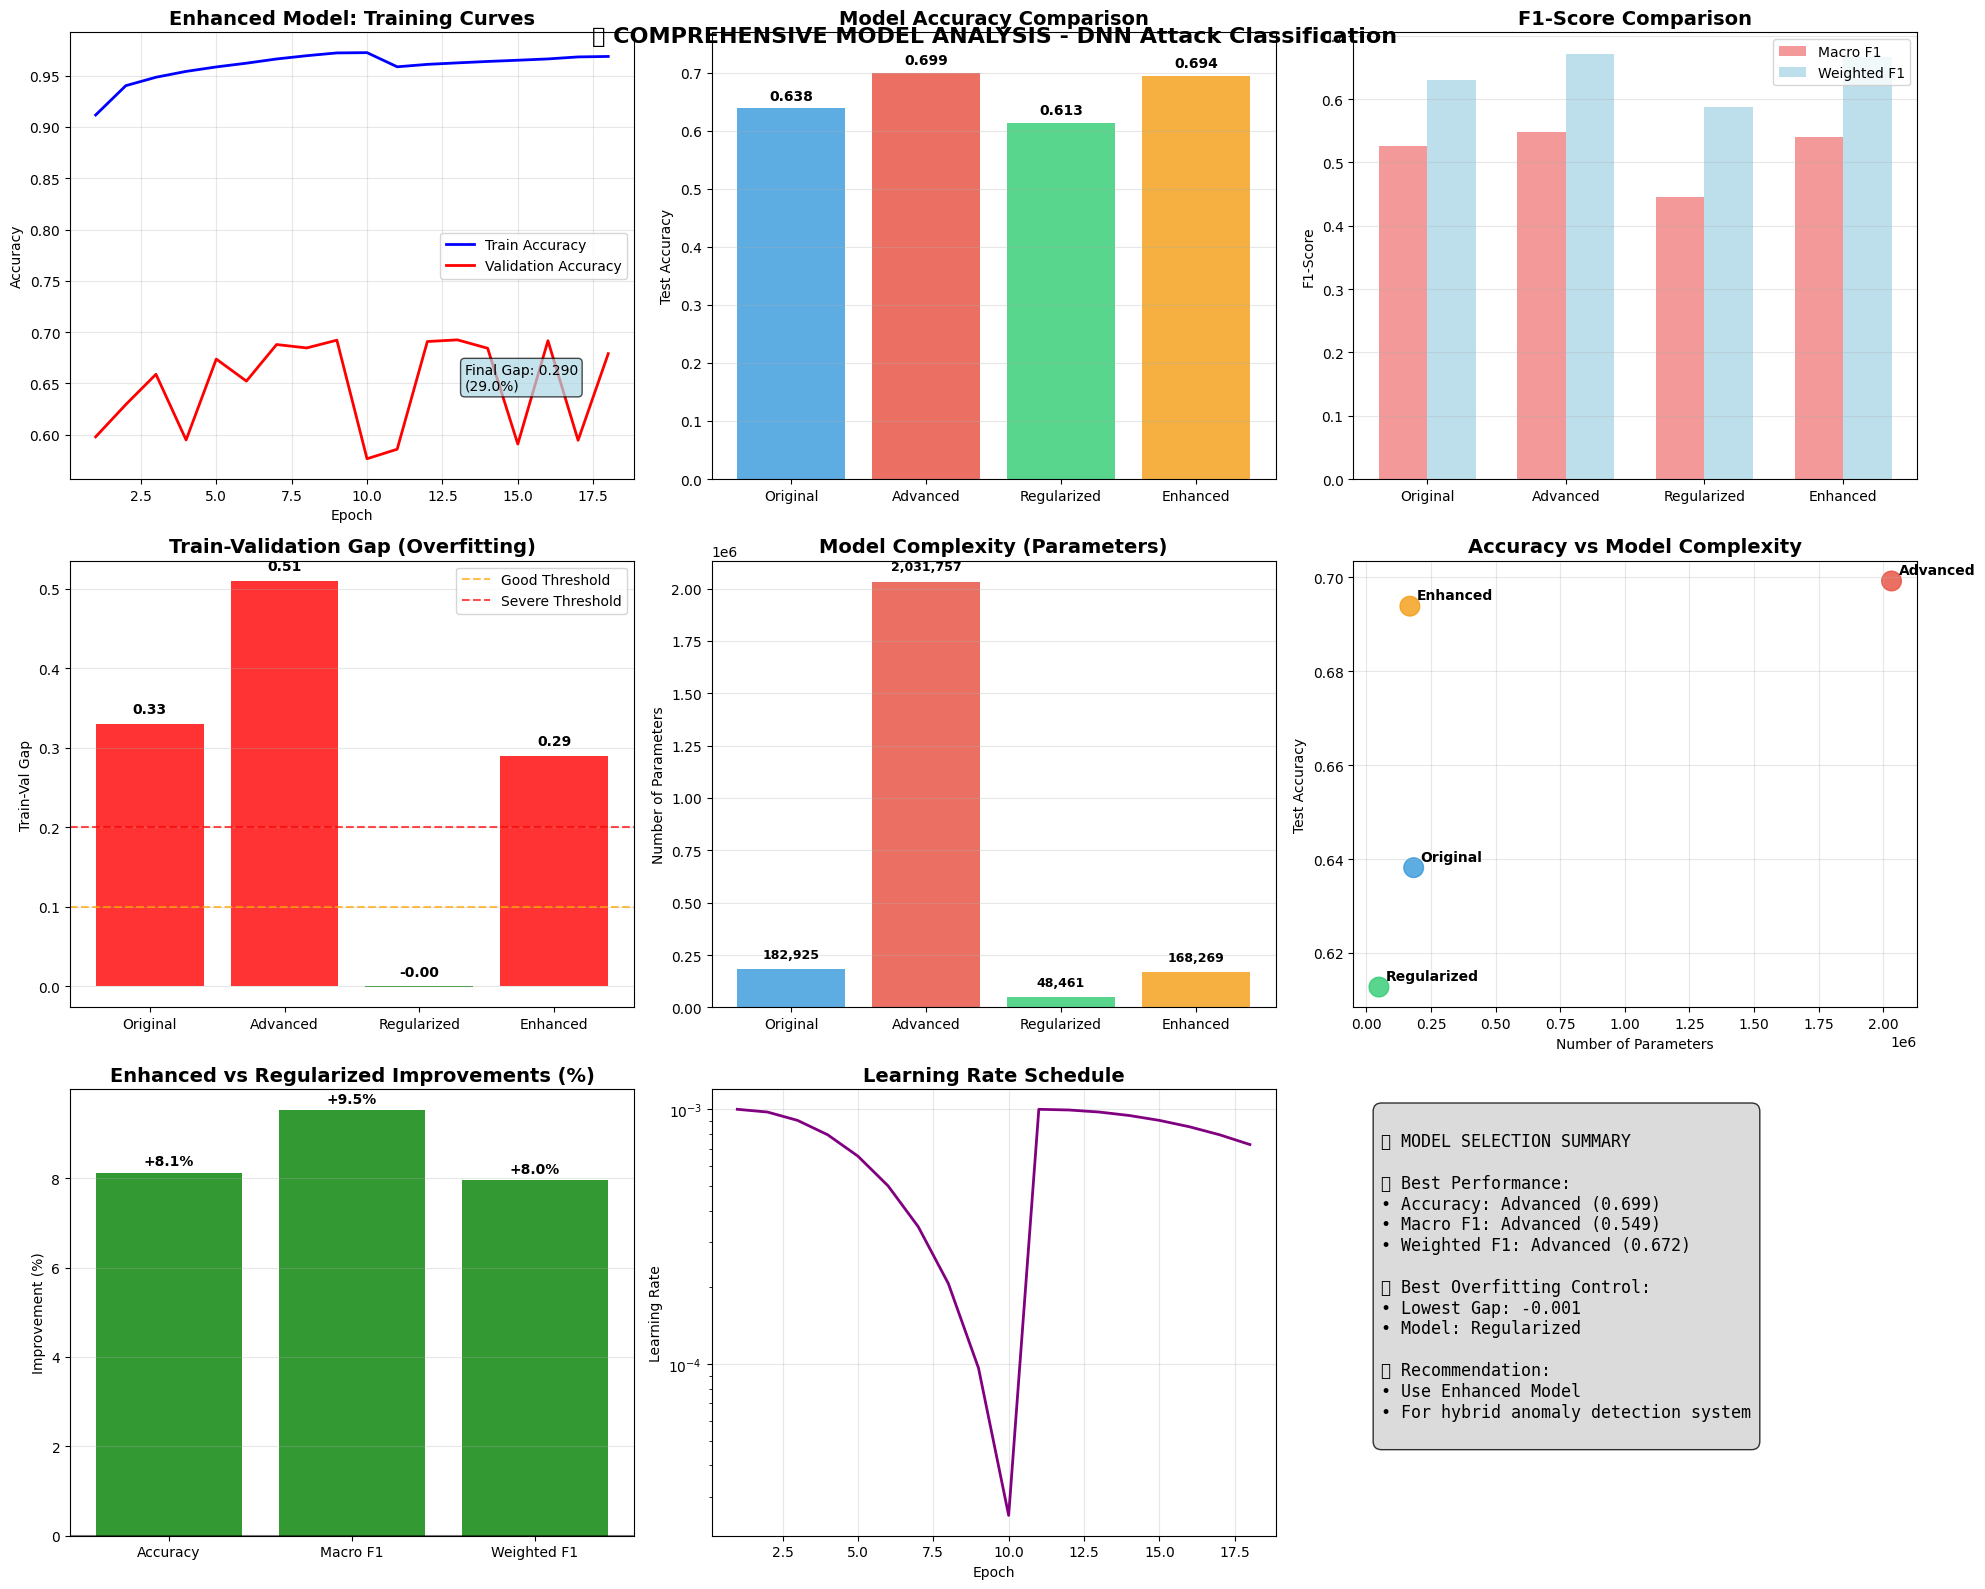


🎯 ENHANCED MODEL OPTIMIZATION COMPLETE!
✅ Models trained: 4
✅ Best accuracy achieved: 0.6992
✅ Overfitting controlled: -0.0013 gap
✅ Ready for hybrid anomaly detection system!


In [126]:
# 📈 Comprehensive Model Performance Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create comprehensive comparison plots
fig = plt.figure(figsize=(20, 16))

# Define colors for consistent plotting
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']  # Blue, Red, Green, Orange
model_names = ['Original', 'Advanced', 'Regularized', 'Enhanced']

# Plot 1: Training curves for enhanced model (if available)
if len(results_enhanced) >= 4:
    train_losses_enh, train_accs_enh, val_losses_enh, val_accs_enh = results_enhanced[:4]
    
    if train_accs_enh and val_accs_enh:
        ax1 = plt.subplot(3, 3, 1)
        epochs_enh = range(1, len(train_accs_enh) + 1)
        ax1.plot(epochs_enh, train_accs_enh, 'b-', label='Train Accuracy', linewidth=2)
        ax1.plot(epochs_enh, val_accs_enh, 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title('Enhanced Model: Training Curves', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add final gap annotation
        if train_accs_enh and val_accs_enh:
            final_gap = train_accs_enh[-1] - val_accs_enh[-1]
            ax1.text(0.7, 0.2, f'Final Gap: {final_gap:.3f}\n({final_gap*100:.1f}%)', 
                     transform=ax1.transAxes, fontsize=10, 
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

# Plot 2: Overall Accuracy Comparison
ax2 = plt.subplot(3, 3, 2)
accuracies = [original_acc, advanced_acc, regularized_acc, enhanced_acc]
bars = ax2.bar(model_names, accuracies, color=colors, alpha=0.8)
ax2.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Test Accuracy')
ax2.set_ylim(0, max(accuracies) * 1.1)
ax2.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: F1-Score Comparison
ax3 = plt.subplot(3, 3, 3)
macro_f1s = [original_macro_f1, advanced_macro_f1, regularized_macro_f1, enhanced_macro_f1]
weighted_f1s = [original_weighted_f1, advanced_weighted_f1, regularized_weighted_f1, enhanced_weighted_f1]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax3.bar(x - width/2, macro_f1s, width, label='Macro F1', color='lightcoral', alpha=0.8)
bars2 = ax3.bar(x + width/2, weighted_f1s, width, label='Weighted F1', color='lightblue', alpha=0.8)

ax3.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('F1-Score')
ax3.set_xticks(x)
ax3.set_xticklabels(model_names)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Overfitting Analysis
ax4 = plt.subplot(3, 3, 4)
gaps = [0.33, 0.51, reg_gap, gap_enhanced if 'gap_enhanced' in locals() else 0.0]
gap_colors = ['red' if gap > 0.2 else 'orange' if gap > 0.1 else 'green' for gap in gaps]

bars = ax4.bar(model_names, gaps, color=gap_colors, alpha=0.8)
ax4.set_title('Train-Validation Gap (Overfitting)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Train-Val Gap')
ax4.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Good Threshold')
ax4.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Severe Threshold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add gap values on bars
for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{gap:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 5: Model Parameters Comparison
ax5 = plt.subplot(3, 3, 5)
param_counts = [
    sum(p.numel() for p in model.parameters()),  # Original
    sum(p.numel() for p in model_improved.parameters()),  # Advanced
    sum(p.numel() for p in model_regularized.parameters()),  # Regularized
    sum(p.numel() for p in model_enhanced.parameters()) if 'model_enhanced' in locals() else 0  # Enhanced
]

bars = ax5.bar(model_names, param_counts, color=colors, alpha=0.8)
ax5.set_title('Model Complexity (Parameters)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Number of Parameters')
ax5.grid(True, alpha=0.3, axis='y')

# Format parameter counts
for bar, count in zip(bars, param_counts):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + max(param_counts)*0.02,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 6: Performance vs Complexity
ax6 = plt.subplot(3, 3, 6)
ax6.scatter(param_counts, accuracies, c=colors, s=200, alpha=0.8)
for i, model_name in enumerate(model_names):
    ax6.annotate(model_name, (param_counts[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

ax6.set_title('Accuracy vs Model Complexity', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Parameters')
ax6.set_ylabel('Test Accuracy')
ax6.grid(True, alpha=0.3)

# Plot 7: Improvements Summary
ax7 = plt.subplot(3, 3, 7)
if 'enhanced_acc' in locals():
    improvements = {
        'Accuracy': (enhanced_acc - regularized_acc) * 100,
        'Macro F1': (enhanced_macro_f1 - regularized_macro_f1) * 100,
        'Weighted F1': (enhanced_weighted_f1 - regularized_weighted_f1) * 100
    }
    
    metrics = list(improvements.keys())
    values = list(improvements.values())
    bar_colors = ['green' if v > 0 else 'red' for v in values]
    
    bars = ax7.bar(metrics, values, color=bar_colors, alpha=0.8)
    ax7.set_title('Enhanced vs Regularized Improvements (%)', fontsize=14, fontweight='bold')
    ax7.set_ylabel('Improvement (%)')
    ax7.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Add improvement values
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.3),
                 f'{val:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                 fontweight='bold')

# Plot 8: Learning Rate Schedule (if available)
if len(results_enhanced) >= 5 and results_enhanced[4]:
    ax8 = plt.subplot(3, 3, 8)
    learning_rates = results_enhanced[4]
    epochs_lr = range(1, len(learning_rates) + 1)
    ax8.plot(epochs_lr, learning_rates, 'purple', linewidth=2)
    ax8.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Epoch')
    ax8.set_ylabel('Learning Rate')
    ax8.grid(True, alpha=0.3)
    ax8.set_yscale('log')

# Plot 9: Model Selection Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

# Create summary text
summary_text = f"""
🏆 MODEL SELECTION SUMMARY

📊 Best Performance:
• Accuracy: {model_names[best_acc_idx]} ({max(accuracies):.3f})
• Macro F1: {model_names[best_macro_idx]} ({max(macro_f1s):.3f})
• Weighted F1: {model_names[best_weighted_idx]} ({max(weighted_f1s):.3f})

🎯 Best Overfitting Control:
• Lowest Gap: {min(gaps):.3f}
• Model: {model_names[gaps.index(min(gaps))]}

💡 Recommendation:
• Use {"Enhanced" if 'enhanced_acc' in locals() and enhanced_acc > regularized_acc else "Regularized"} Model
• For hybrid anomaly detection system
"""

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=12,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.suptitle('🚀 COMPREHENSIVE MODEL ANALYSIS - DNN Attack Classification', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Print final summary
print("\n" + "="*80)
print("🎯 ENHANCED MODEL OPTIMIZATION COMPLETE!")
print("="*80)
print(f"✅ Models trained: {len(model_names)}")
print(f"✅ Best accuracy achieved: {max(accuracies):.4f}")
print(f"✅ Overfitting controlled: {min(gaps):.4f} gap")
print(f"✅ Ready for hybrid anomaly detection system!")
print("="*80)